# Time Series Analysis and Forecasting

This is a series of notebooks to support lectures on _Time series analysis and forecast_.

![](https://user-images.githubusercontent.com/49638680/154160268-cf39a1ec-3557-4940-8853-d06fc7a79acf.png)

## Time series Forecast

In paticular, over this notebook we are going to explore techniques to build a forecasting models based on time series. We are also going to explore how to split time series data into train, test and validation sets.

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from utils.helpers import regression_results, rmse, parser

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

In [2]:
data_url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(data_url,
                 parse_dates=True,
                 index_col='Date')


In [3]:
df

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

## Train/test/validation split

**The problem** If we split data in train/test/validation in the usual way _i.e._ shuffling data and randomly picking a certain amount of data, we would spoil the time-ordering of data and we could miss the relation between one example and the  "next" one.

**The solution** Look at the image below.
 
![](https://i.stack.imgur.com/2KHMQ.png)

We are going to implement such a structure thanks to `sklearn` module, [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

First of all let's put ourself into a clear example, defining our modeling/forecasting task.

### Goals of Prediction
Our aim is to predict `Consumption` (ideally for future unseen dates) from the OPSD time series dataset.

### Shift in data
Time series are somehow special since the feature engineering needs to take into account that the "past" labels are also features for future data.
Hence, we want to create a new column taking the shift of `Consumption`.

In [4]:
# creating new dataframe from consumption column
data_consumption = df[['Consumption']]

In [5]:
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'Consumption'].shift()

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()

In [7]:
# dropping NaNs
data_consumption = data_consumption.dropna()

In [8]:
# set frequency
data_consumption.index = data_consumption.asfreq('D').index

In [9]:
data_consumption

Consumption   Yesterday  Yesterday_Diff
Date                                               
2006-01-03   1442.53300  1380.52100       311.33700
2006-01-04   1457.21700  1442.53300        62.01200
2006-01-05   1477.13100  1457.21700        14.68400
2006-01-06   1403.42700  1477.13100        19.91400
2006-01-07   1300.28700  1403.42700       -73.70400
...                 ...         ...             ...
2017-12-27   1263.94091  1130.11683        18.83345
2017-12-28   1299.86398  1263.94091       133.82408
2017-12-29   1295.08753  1299.86398        35.92307
2017-12-30   1215.44897  1295.08753        -4.77645
2017-12-31   1107.11488  1215.44897       -79.63856

[4381 rows x 3 columns]

### Train-test split
Here the procedure as descripted in the figure above requires some manual coding since it is a sort of _grid searching_ of hyperparameters over different (successive) chunks of data.

First of all, we want to use all the years before $2016$ as training and leave the $2017$ as test data.

In [10]:
X_train = data_consumption.loc[:'2016'].drop(['Consumption'], axis = 1).values
y_train = data_consumption.loc[:'2016', 'Consumption'].values

X_test = data_consumption.loc['2017'].drop(['Consumption'], axis = 1).values
y_test = data_consumption.loc['2017', 'Consumption'].values

Hence, we are now ready to perform the TimeSeriesSplit as described above.

LR: 0.343747 (0.029773)
NN: 0.244708 (0.163085)
KNN: 0.646307 (0.083185)
RF: 0.614813 (0.098658)
SVR: -0.117944 (0.157755)


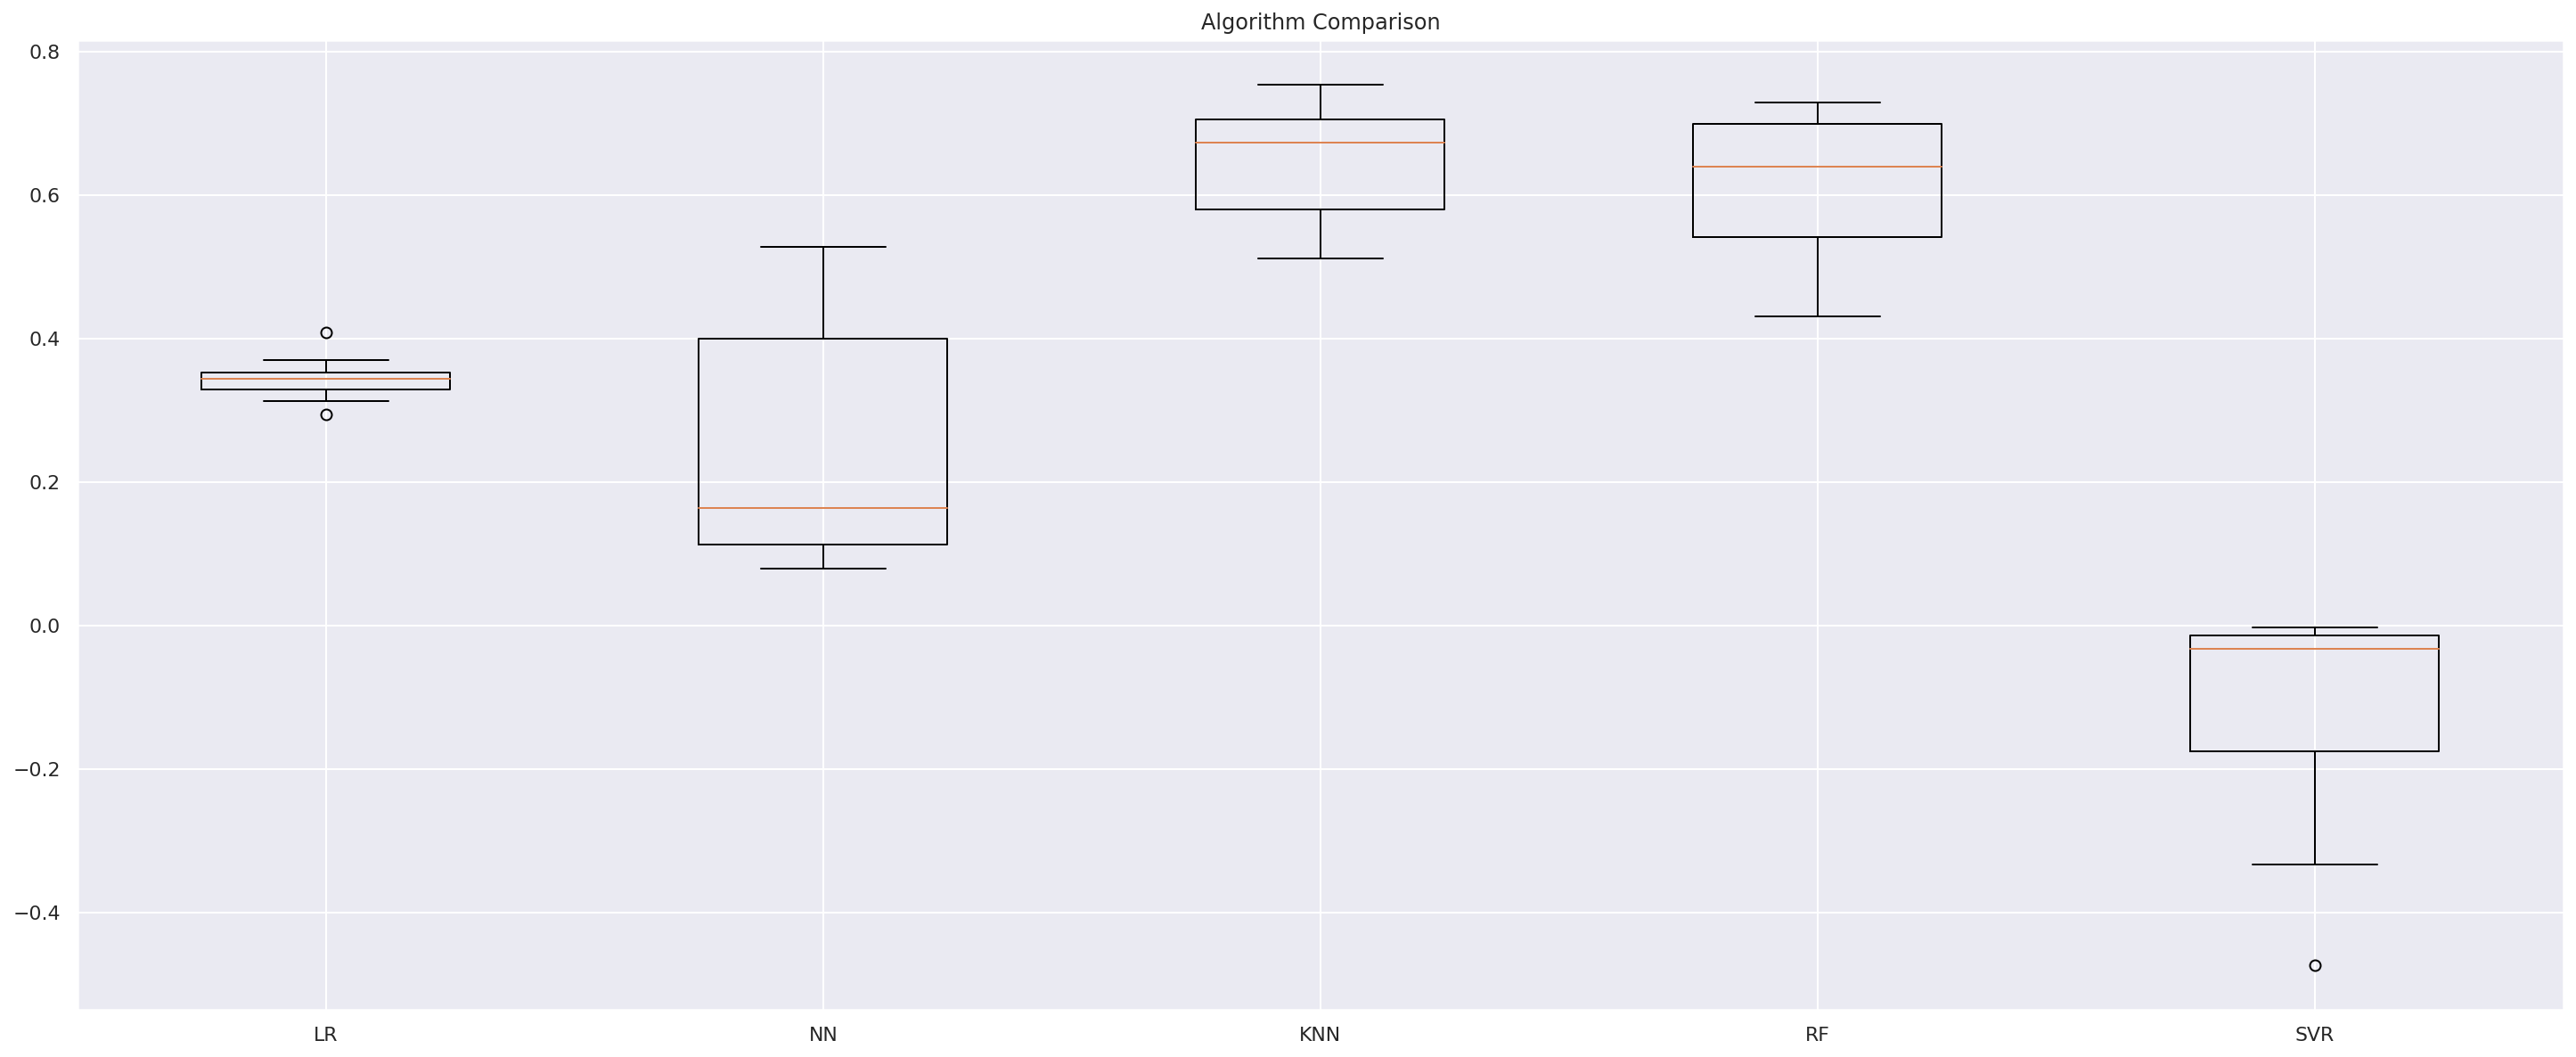

In [11]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(hidden_layer_sizes=(32, 8), solver = 'adam', max_iter=2000)))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Both KNN and RF perform equally well. But I personally prefer RF since this ensemble model (combine multiple ‘individual’ (diverse) models together and deliver superior prediction power.) can almost work out of the box and that is one reason why they are very popular.

#### Hyperparameters tuning
Aiming principle:
> An optimal combination of hyperparameters maximizes a model’s performance without leading to a high variance problem (overfitting).

Hence we are going to make use of sklearn `GridSearchCV` to perform hyperparamenter tuning.

__Note__: the following cell may take some time to run.

In [12]:
rmse_score = make_scorer(rmse, greater_is_better = False)
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

#### Evaluate on test data

In [13]:
y_pred = best_model.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.7352
mean_squared_log_error:  0.004
r2:  0.7332
MAE:  55.0846
MSE:  7226.2684
RMSE:  85.0075


### A Visualisation Example

In [14]:
data_consumption['pred_Consumption'] = best_model.predict(data_consumption.drop(['Consumption'], axis=1))

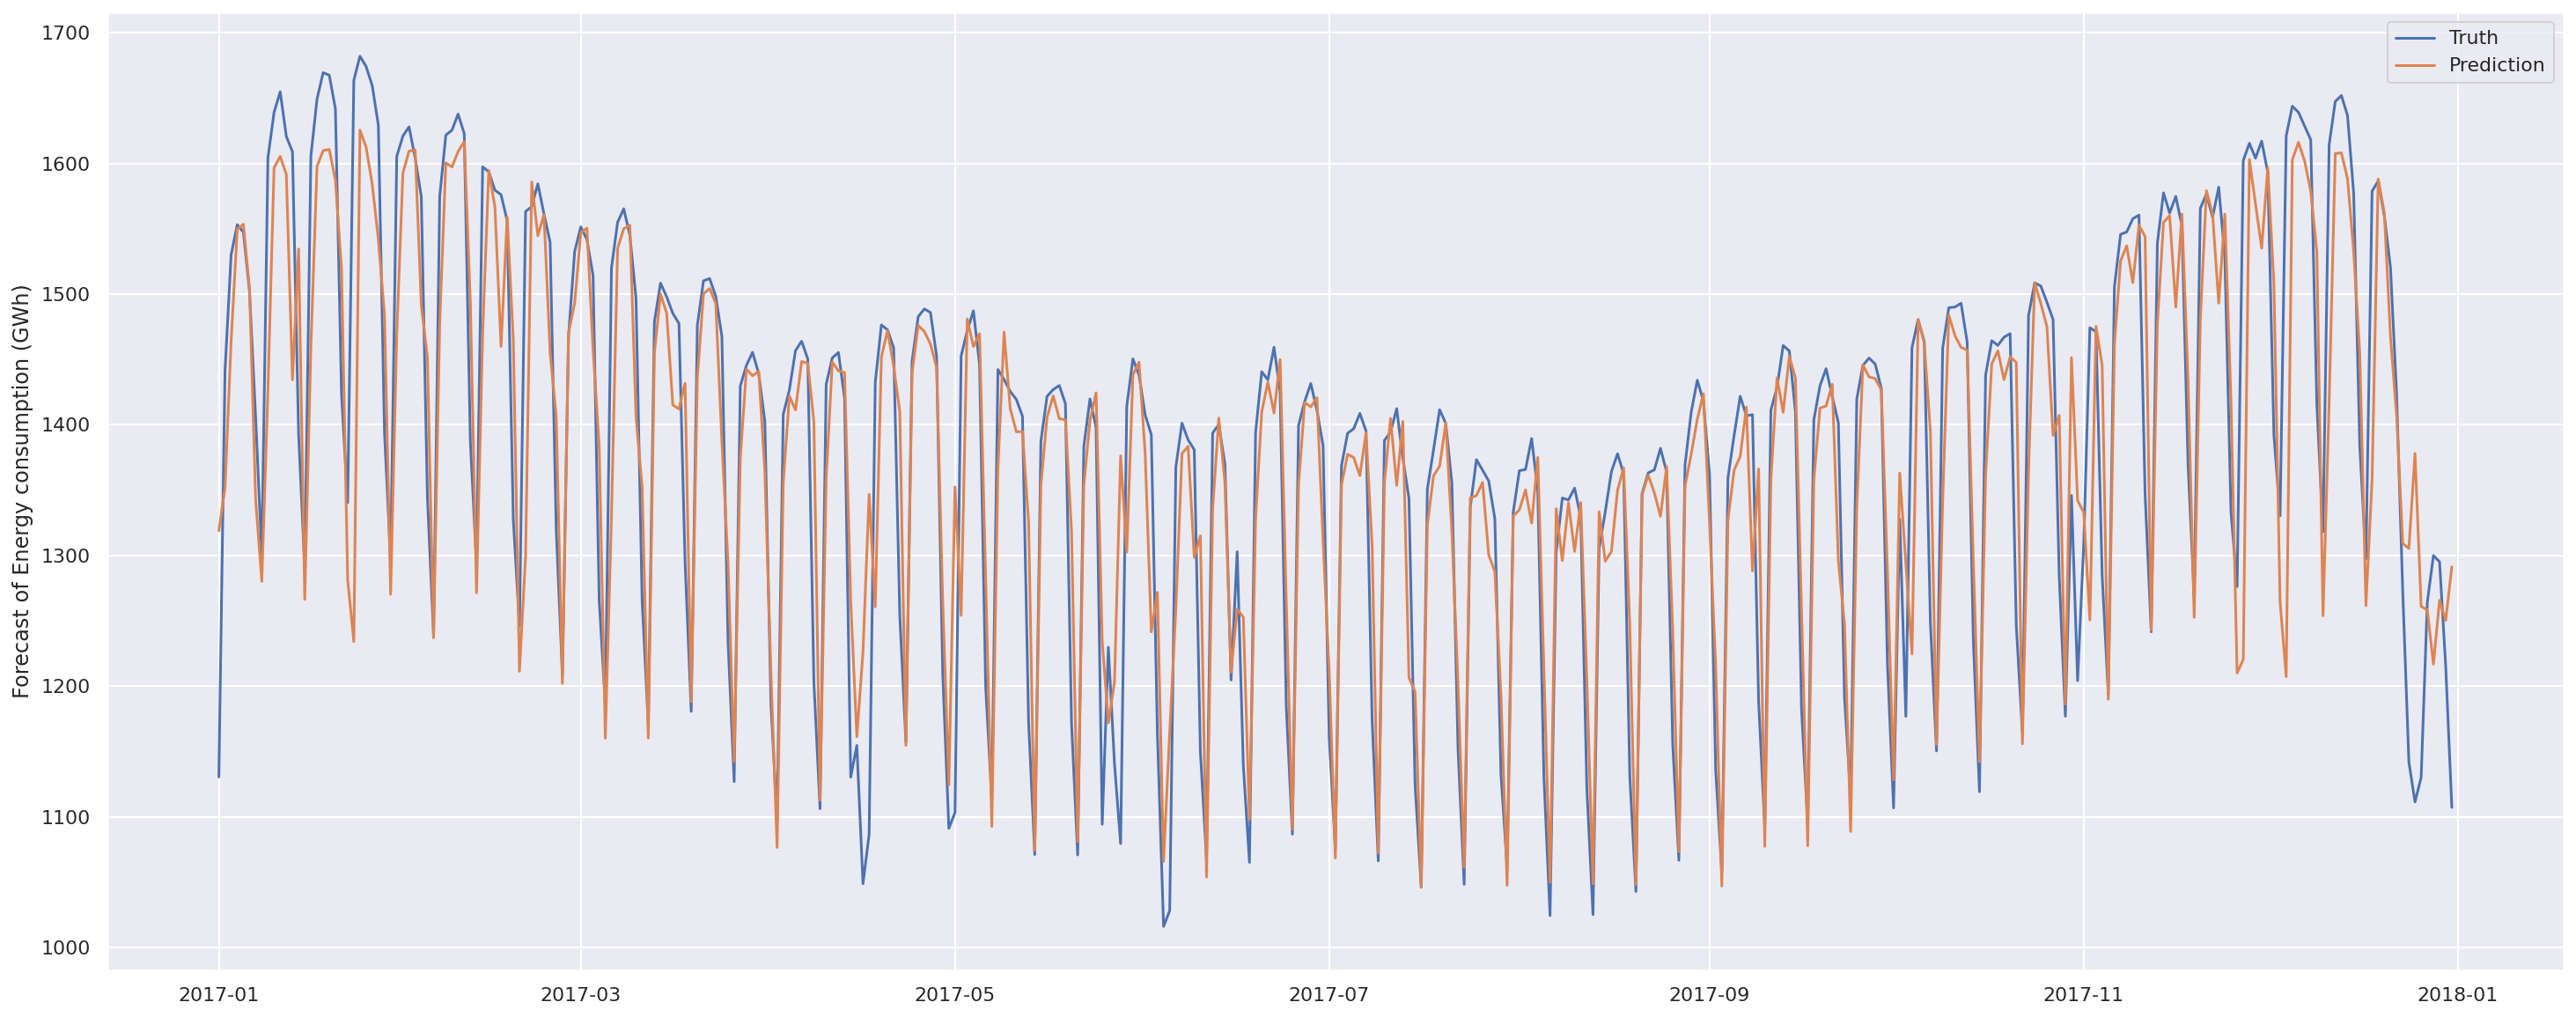

In [15]:
plt.plot(data_consumption['Consumption']['2017'],
         label='Truth')
plt.plot(data_consumption['pred_Consumption']['2017'],
         label='Prediction')

plt.ylabel('Forecast of Energy consumption (GWh)')
plt.legend();

### ARIMA model

We have already seen how to model time series with a based on AutoRegressive models. Here we want to take advantage of such modeling in order to perform forecast.

Indeed, the main idea behind ARIMA is to describe and learn the autocorrelation of a time series.

#### Covariance, correlation and autocorrelation
Recall that covariance measures how much two random variables (or a bivariate sample) vary together. If greater/lower values of one variables correspond to greater/lower values of the other, than the covariance is positive. If it's the opposite, the covariance is negative.

$$\mathrm{cov}(x, y) := \frac{1}{N-1}\sum_i (x_i - \mu_x)(y_i - \mu_y)\, .$$

Hence, the sign of the covariance shows the tendency of the linear relationship between the two variables. However, covariance's magnitude is hard to interpret.

The normalized version of the covariance is called _correlation_; the correlation coefficient is a unit-less number between -1 (perfect negative linear relationship) and 1 (perfect positive linear relationship). A correlation (as well as a covariance) of 0 implies no linear relationship.

$$\rho(x,y) := \frac{\mathrm{cov}(x,y)}{\sigma_x^2\sigma_y^2} = \frac{\sum_i (x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum_i (x_i - \mu_x)^2 \sum_j(y_j - \mu_y)^2}}\, .$$

The figure below shows examples of the correlation of bivariate data.

![](https://camo.githubusercontent.com/7c1955a0e0cc971487e8fc3ecfe4cef9f767dc64bf9d0df294baadc63154765e/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f642f64342f436f7272656c6174696f6e5f6578616d706c6573322e7376672f3139323070782d436f7272656c6174696f6e5f6578616d706c6573322e7376672e706e67)


If correlation quantifies the linear relationship between two random variables, [autocorrelation](https://otexts.com/fpp2/autocorrelation.html) measures such relationship between lagged values of a time series. That is, between shifted version of the same temporal signal.

$$\gamma_\kappa := \rho(x_t, x_{t-\kappa}) = \frac{\sum_{t=\kappa+1}^T (x_t - \mu_x)(x_{t-k\kappa} - \mu_y)}{\sum_t (x_t - \mu_x)^2}\, .$$

There is an autocorrelation coefficient for each choice of the lag $\kappa$. For example, $\gamma_1$ measures the linear relationship between $x_t$ and $x_{t-1}$, $\gamma_2$ between $x_{t}$ and $x_{t-2}$, and so on.

#### Correlograms and white noise
A correlogram (also known as **ACF**, _autocorrelation function_) plots the autocorrelation coefficients $\gamma_\kappa$ for each lag $\kappa$.

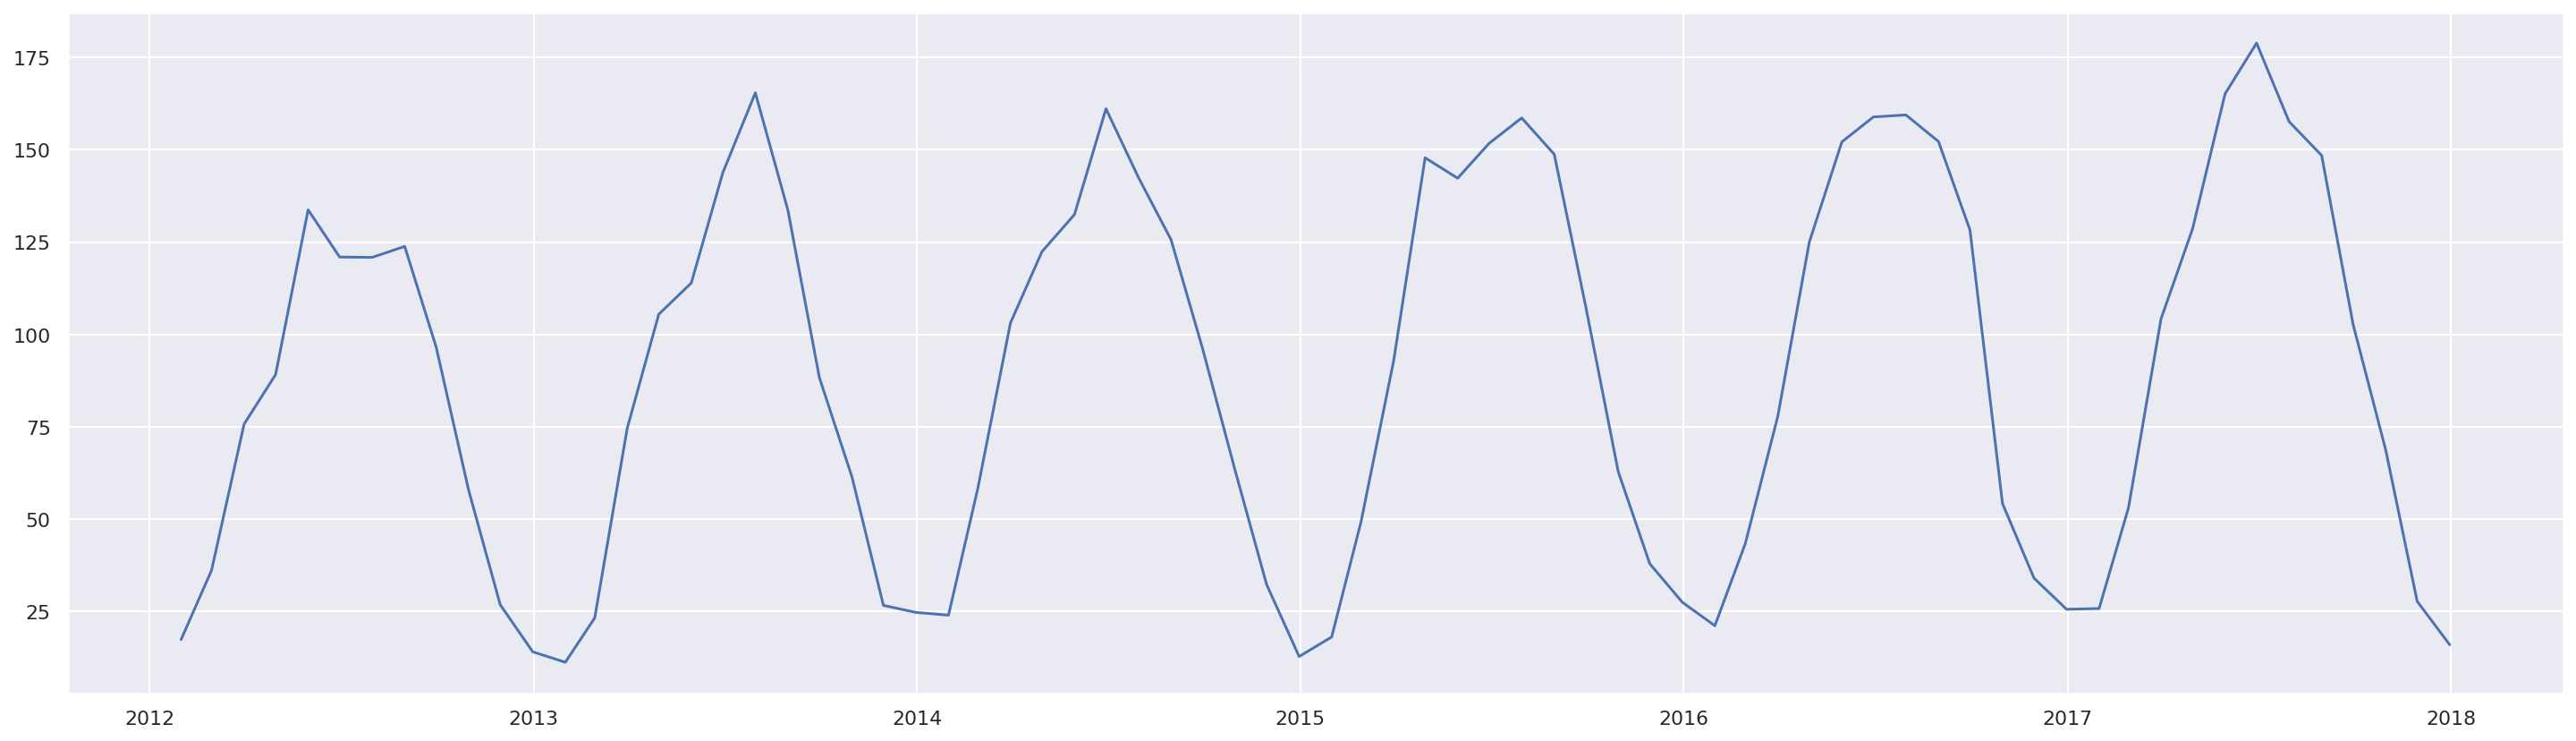

In [16]:
df_solar = df['Solar'].resample('M').mean().dropna()

plt.figure(figsize=(25,7))
plt.plot(df_solar);

The `plot_acf` function in statsmodels has an argument `lags` allowing to set the $\kappa$ lag.

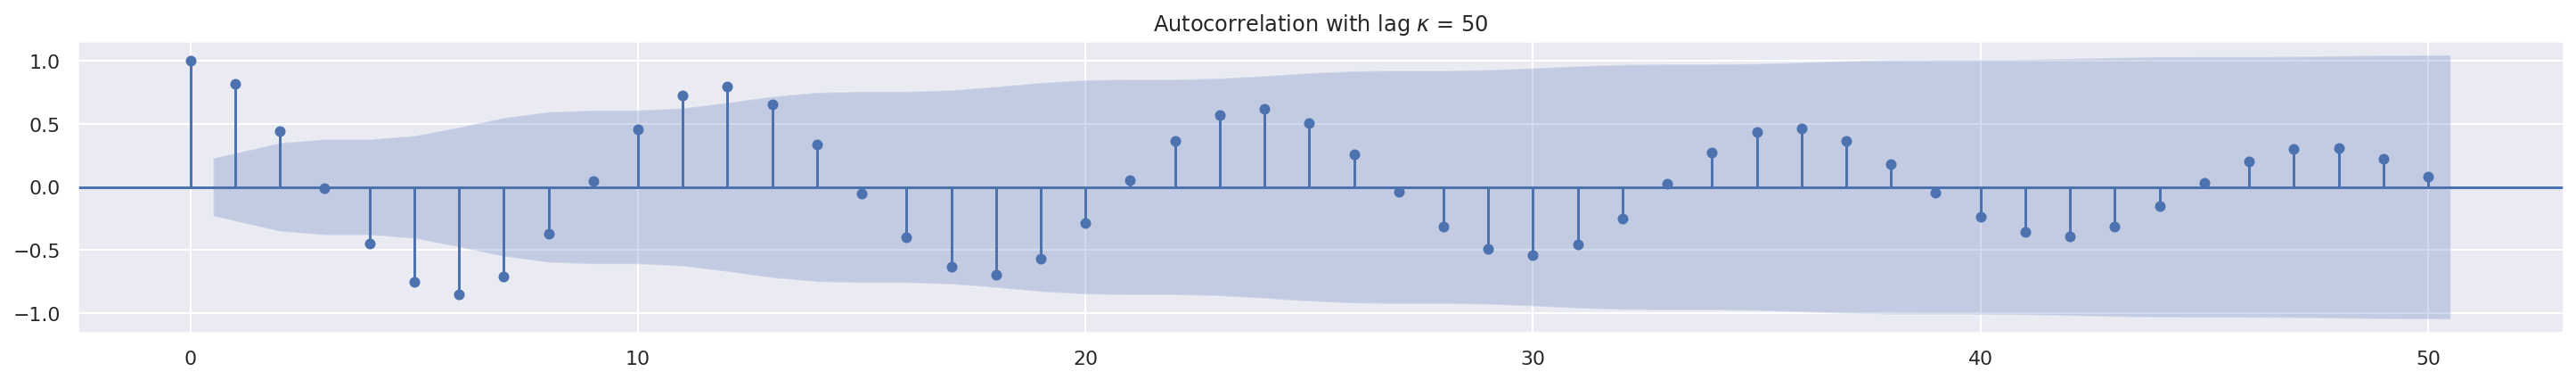

In [17]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df_solar, ax=ax, lags=50)
plt.title(r'Autocorrelation with lag $\kappa$ = 50');

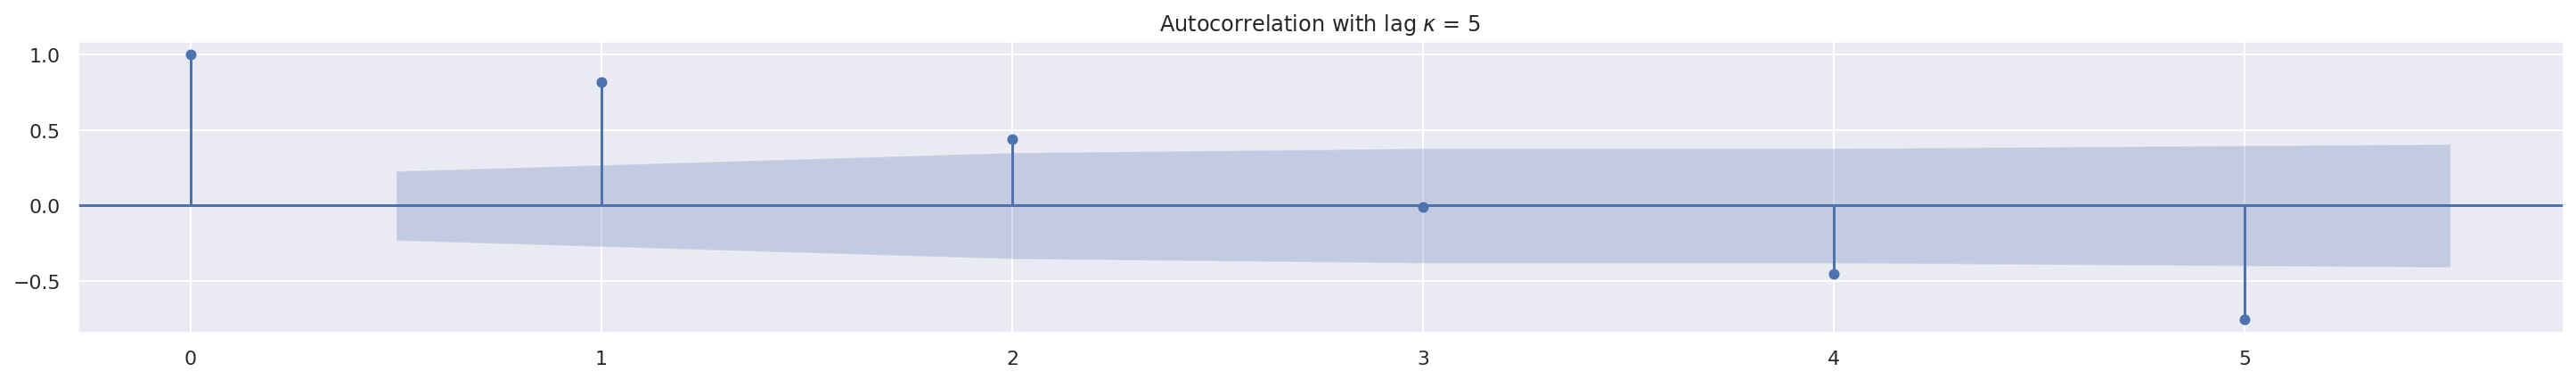

In [18]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df_solar, ax=ax, lags=5)
plt.title(r'Autocorrelation with lag $\kappa$ = 5');

A few comments on the above plots:

* $\gamma_0$ is the $0$-lag autocorrelation; thus, its value is always $1$.
* higher _peaks_ are observed at lags multiple of 12; indeed, the seasonality of the series is yearly
* lower _troughs_ are six lags (=months) behind peaks
* the (absolute) height of the pins decreases over time, as the signal's correlation with its past gets weaker
* conversely, the blue shadowed area (by default, delimiting a 95% confidence interval on the height of the pins) gets larger at higher lags; why?

**Note**: confidence intervals are among the trickiest stats concepts for a data scientist to grasp. An intuitive (yet not totally correct) explanation is that a 95% confidence interval for "something" has the 95% probability of containing that "something". For a nicer and more scientifical explanation, see [here](https://statisticsbyjim.com/hypothesis-testing/confidence-prediction-tolerance-intervals/) and [here](https://www.graphpad.com/support/faq/the-distinction-between-confidence-intervals-prediction-intervals-and-tolerance-intervals/).

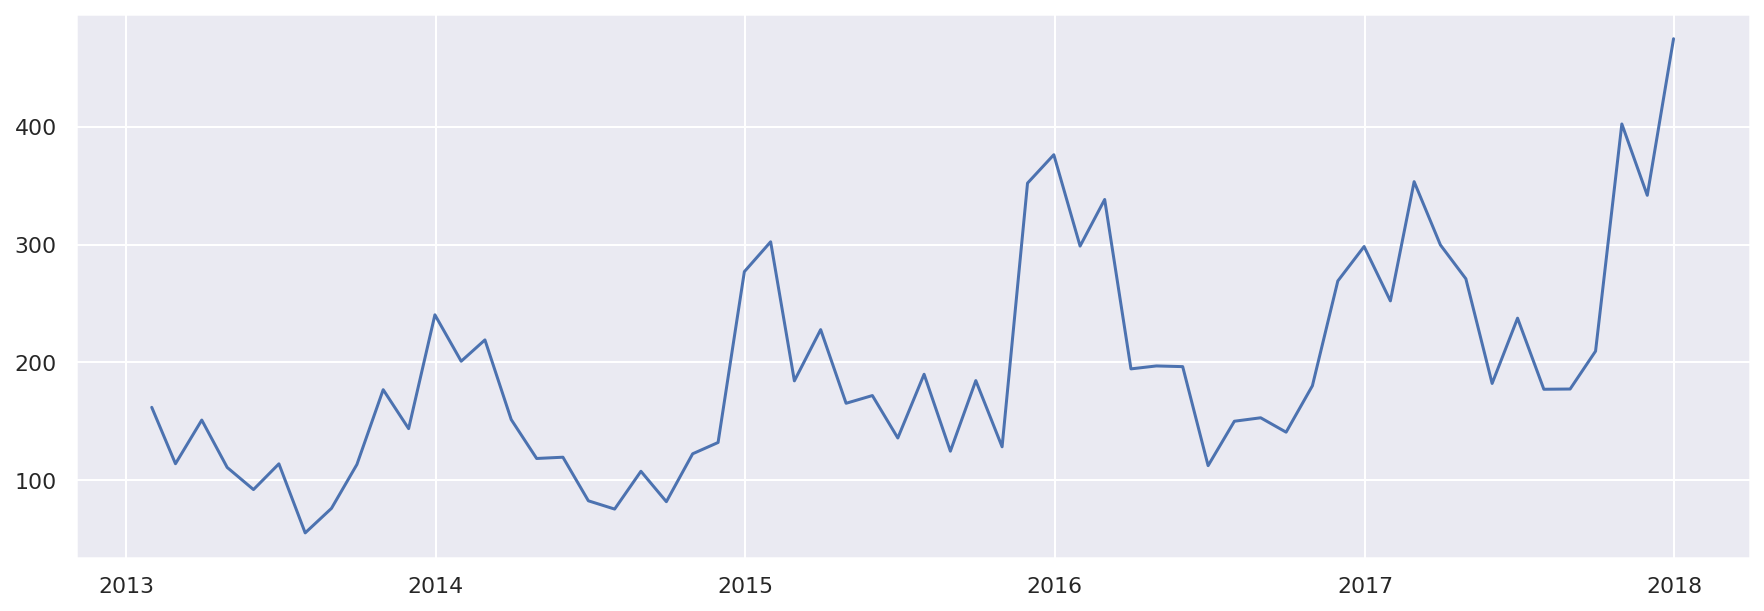

In [19]:
df_wind = df['Wind'].loc['2013':].resample('M').mean().dropna()

plt.figure(figsize=(15,5))
plt.plot(df_wind);

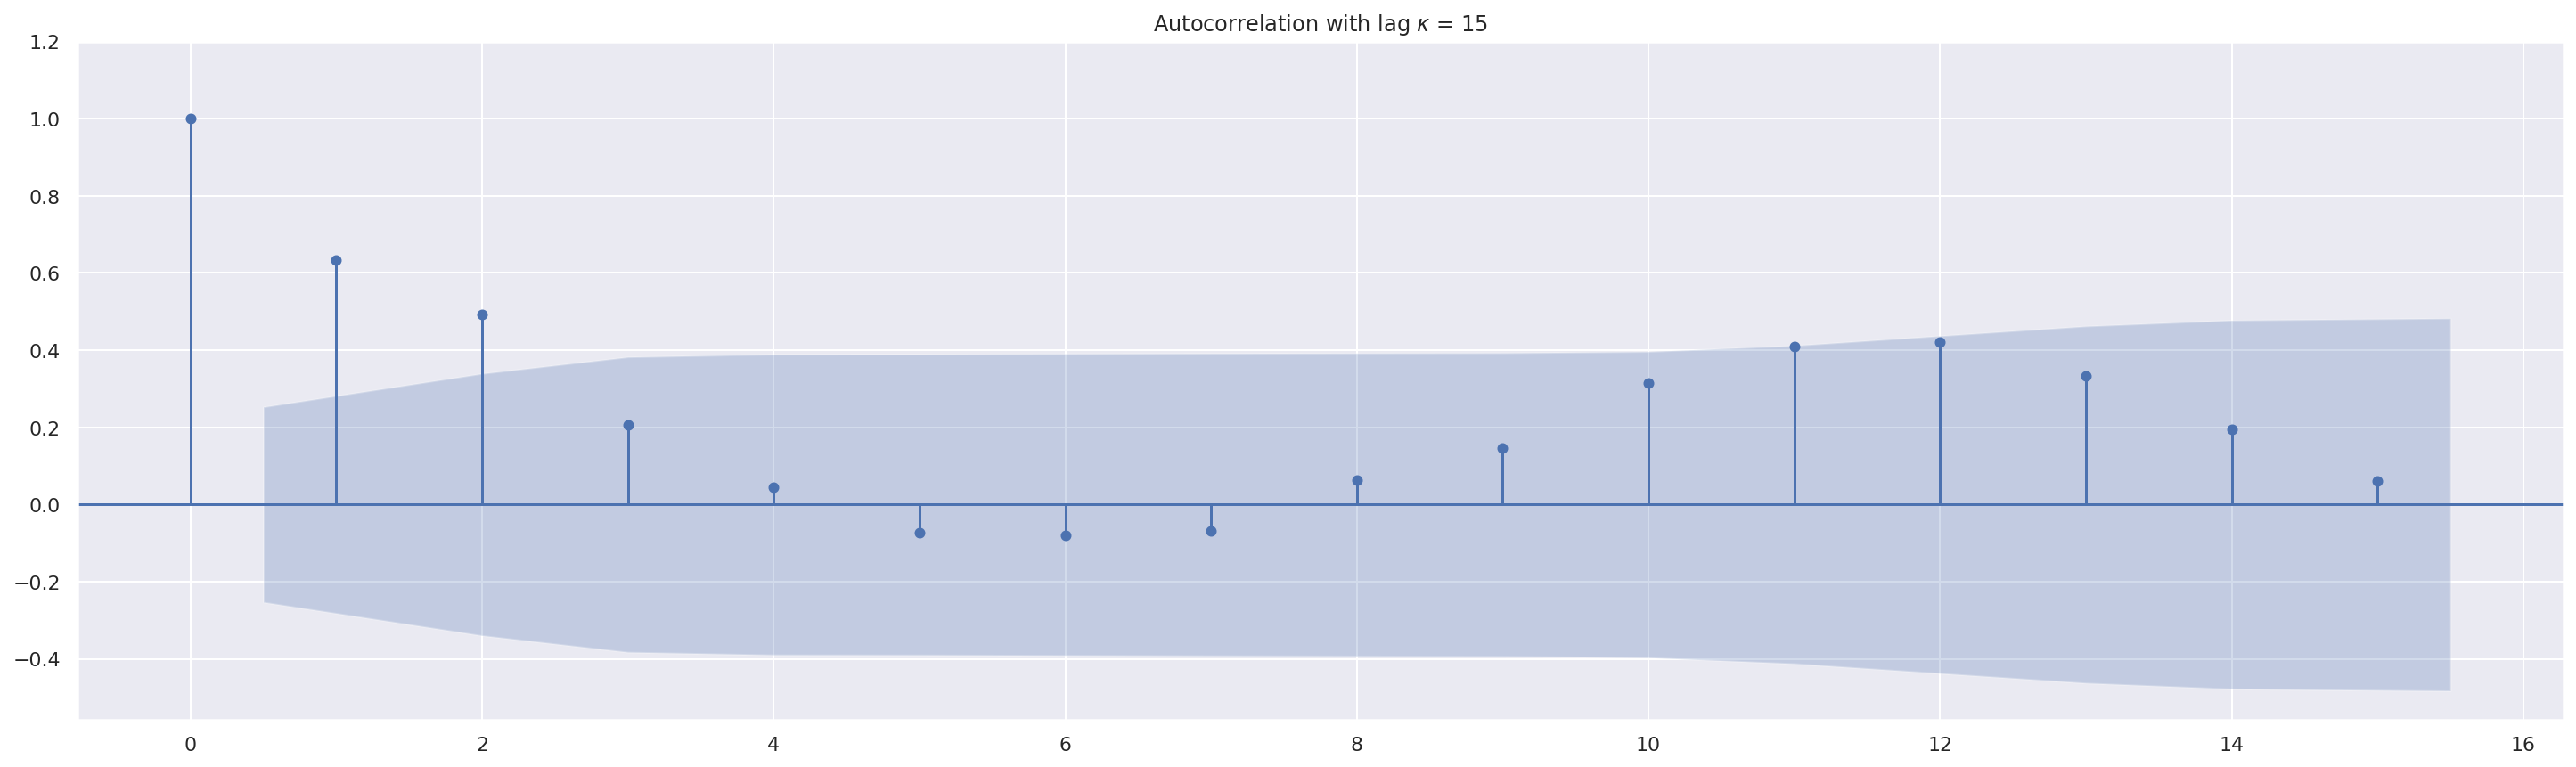

In [21]:
fig, ax = plt.subplots(figsize=(25,7))
_ = plot_acf(df_wind, ax=ax, lags=15)
plt.ylim(top=1.2)
plt.title(r'Autocorrelation with lag $\kappa$ = 15');

One can see although the seasonality of wind energy production is still yearly, this series also shows a strong trend.

This has the effect of "lifting" the first pins of the ACF plot: the autocorrelations for small lags tend to be large and positive, because [observations nearby in time are also nearby in size](https://otexts.com/fpp2/autocorrelation.html#autocorrelation).

A series that shows no autocorrelation at all is called white noise. Copy-pasting from [Wikipedia](https://en.wikipedia.org/wiki/White_noise):

> *[...] a sequence of serially uncorrelated random variables with zero mean and finite variance. [...] one may also require that the samples have identical probability distribution. [...] if each sample has a normal distribution with zero mean, the signal is said to be additive white **Gaussian noise**.*

We can easily generate an example.

In [20]:
np.random.seed(0)
np.random.normal(loc=0, scale=1, size=50)

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
        0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
        0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
       -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
       -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028])

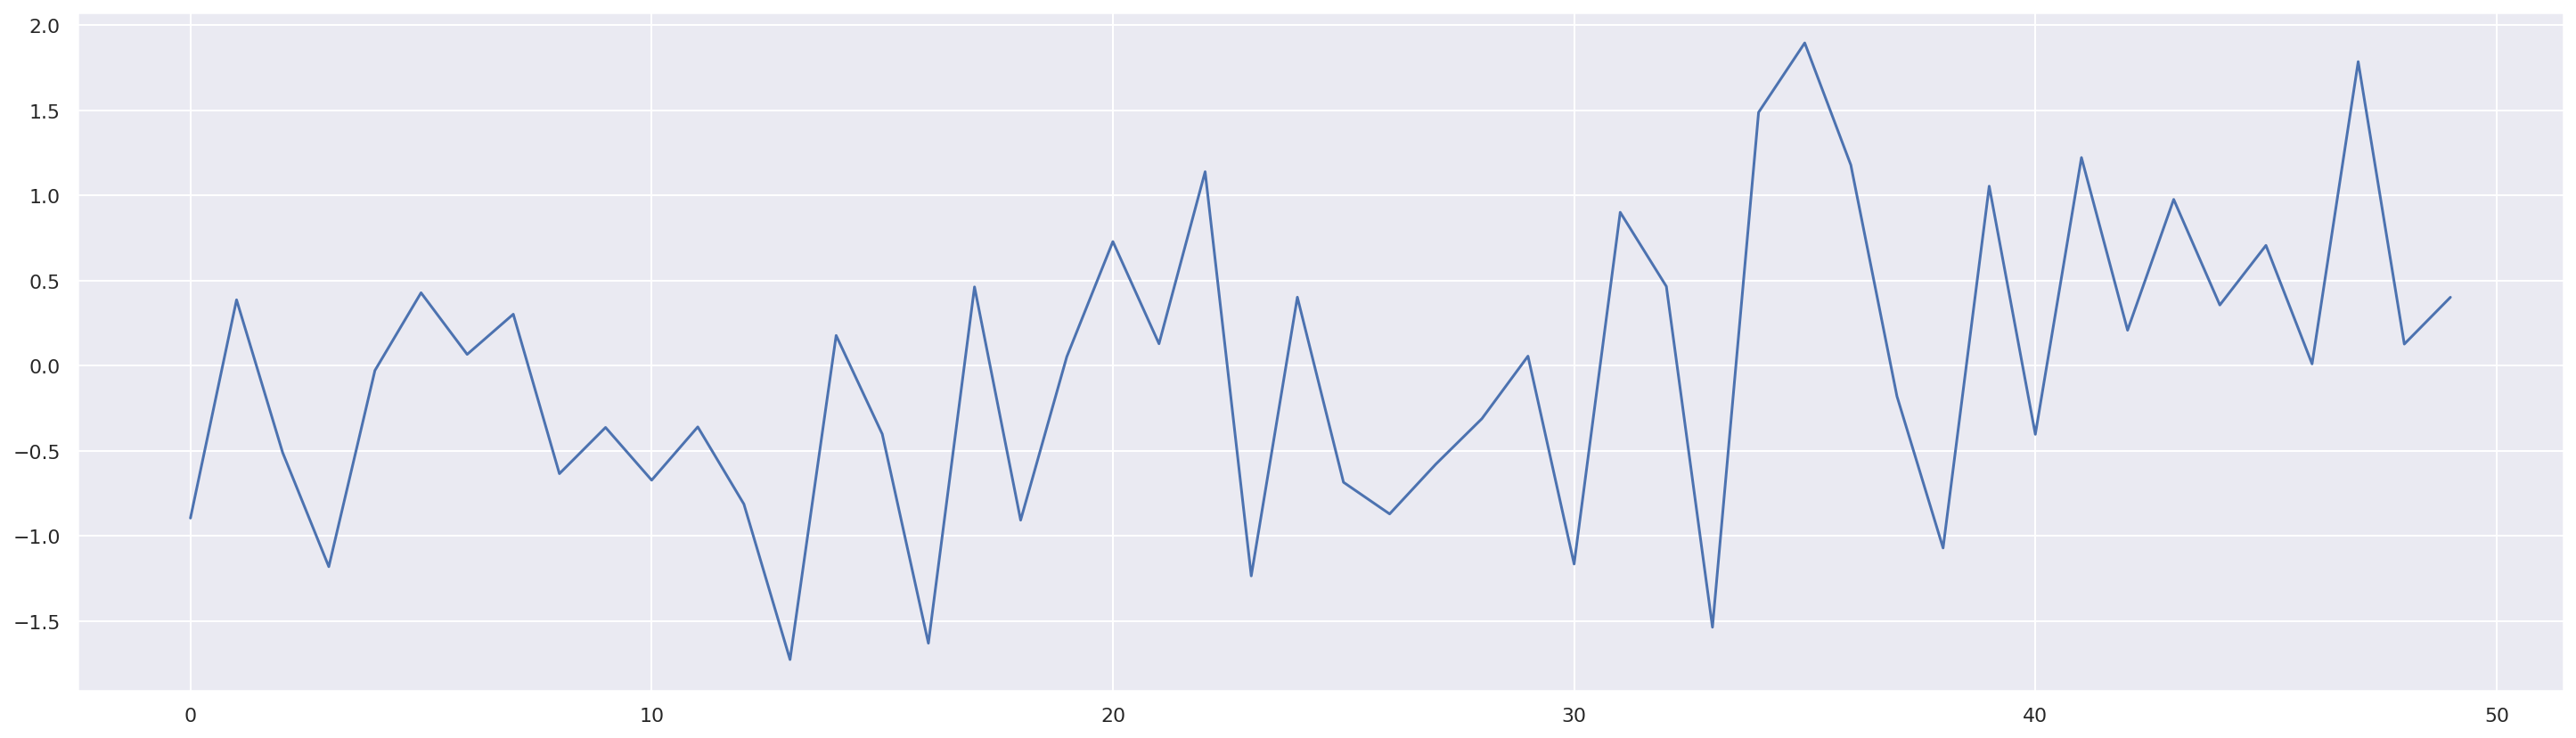

In [22]:
gwn_series = np.random.normal(loc=0, scale=1, size=50)
gwn_series = pd.Series(gwn_series)

fig, ax = plt.subplots(figsize=(25,7))
gwn_series.plot();

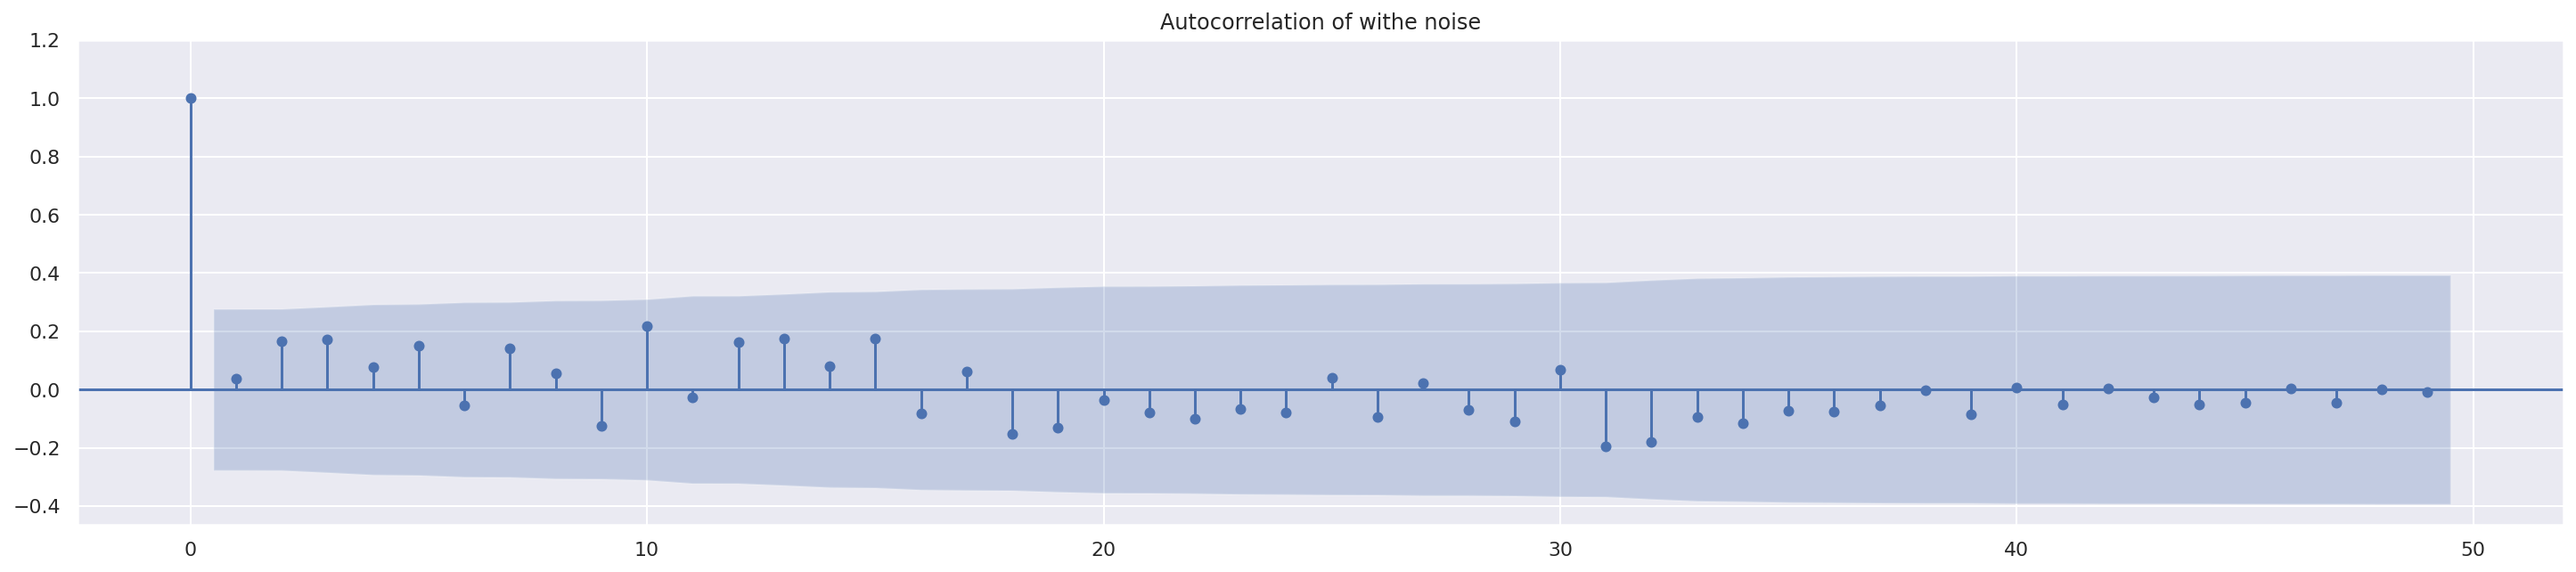

In [23]:
fig, ax = plt.subplots(figsize=(25,5))
_ = plot_acf(gwn_series, ax=ax, lags=49)
plt.ylim(top=1.2)
plt.title("Autocorrelation of withe noise");

_Rule of thumb_: if some (more than the 5%) of the pins sprout out the shadowed area, than the signal is probably not white noise.

### Partial Autocorrelation Function (PACF) 
This measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. _E.g._ at lag $5$, it will check the correlation but remove the effects already explained by lags $1$ to $4$.

We can plot such a function by the `plot_pacf` module in statsmodels.

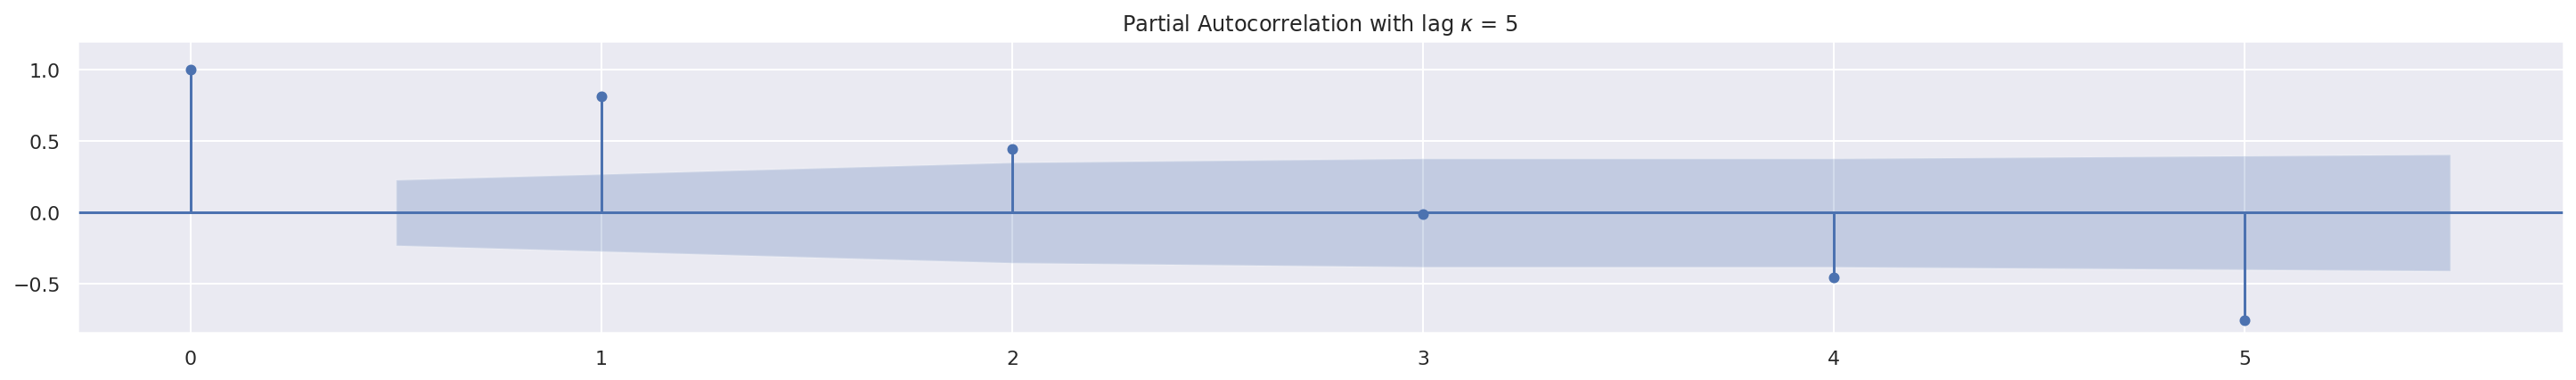

In [24]:
ig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(df_solar, ax=ax, lags=5)
plt.ylim(top=1.2)
plt.title(r'Partial Autocorrelation with lag $\kappa$ = 5');

### Further reading
[This](https://otexts.com/fpp2/arima.html) and [this](https://people.duke.edu/~rnau/411home.htm) are nice resources you can use to approach ARIMA as well as other models and concepts of statistical forecasting.

In the following we are going to build an ARIMA prediction model. Then, in the Extra resources section of this notebook you can find the links to two further Python implementations of ARIMA. 

__Important implementation note:__ ARIMA, together with the other models implemented in statsmodels, does not support _multivariate_ time series.
### Example of ARIMA Model

Recall that the ARIMA model takes three parameters $(d, p, q)$, whose significance is maybe clearer looking at the equations below:

$$\left(1 - \sum_{i=1}^p \phi_k L^k \right)y(t) = \left(1 + \sum^q_{j=1} \theta_j L^j\right) \varepsilon(t) \, .$$

where, 

$$y(t) = (1-L)^d x(t)\, .$$

Hence the stastmodels implementation will take a tuple $(p, d, q)$ as an argument.

_Note_: Setting alternatively $p$, $d$ or $q$ to special values, we can get noteworthy models:

* An ARIMA(0, 1, 0) model (or I(1) model) is given by $X_{t}=X_{t-1}+ \varepsilon_{t}$ — which is simply a random walk.
* An ARIMA(0, 1, 0) with a constant, given by $X_{t}=c+X_{t-1}+\varepsilon _{t}$ — which is a random walk with drift.
* An ARIMA(0, 0, 0) model is a white noise model.
* An ARIMA(0, 1, 2) model is a Damped Holt's model.
* An ARIMA(0, 1, 1) model without constant is a basic exponential smoothing model.

#### AR model

Let's start by $(p,d, q) = (\kappa, 1, 0)$, hence an AR model (autoregressive only).

Let's evaluate the autocorrelatin plot

/opt/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


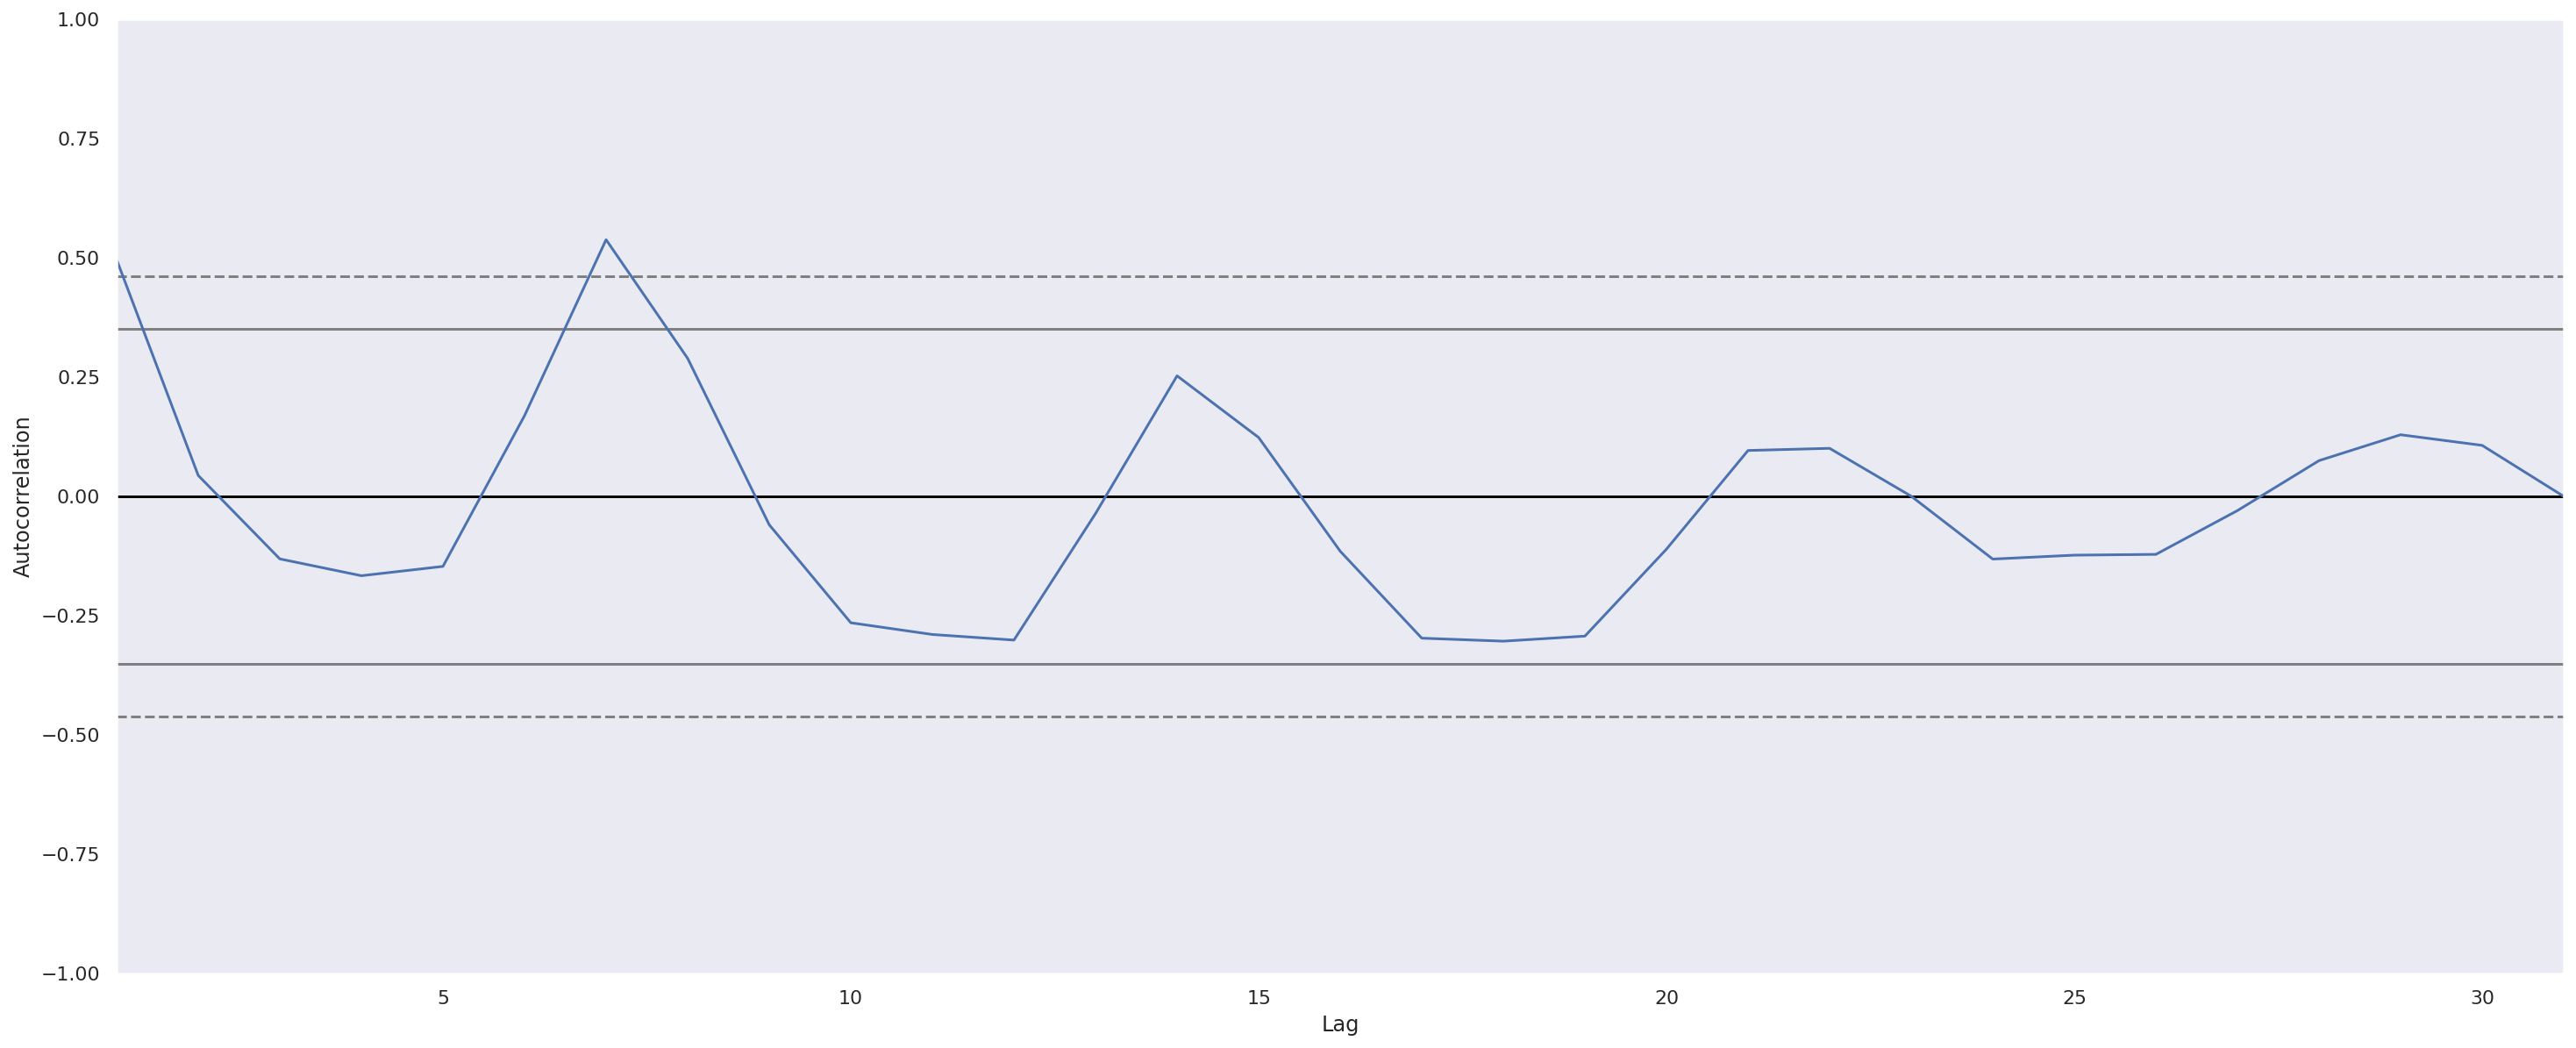

In [25]:
pd.plotting.autocorrelation_plot(data_consumption['Consumption'].loc['2016-01-01':'2016-01-31']);

The plot above prints a _summary_ of the autocorrelation as a function of lags. We can see the time series is not _stationary_ hence in order to bring it back to a stationary one we need to _differencing_ it of some lag. Here the first appropriate lag is $7$ hence our $d$. 

In [26]:
model = ARIMA(data_consumption['Consumption'].loc[:'2017'], order=(7, 1, 0))  
results_AR = model.fit()  
print(results_AR.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                 4381
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -24868.711
Date:                Mon, 21 Feb 2022   AIC                          49753.422
Time:                        16:49:30   BIC                          49804.501
Sample:                    01-03-2006   HQIC                         49771.445
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3463      0.010    -35.367      0.000      -0.365      -0.327
ar.L2         -0.4321      0.011    -38.543      0.000      -0.454      -0.410
ar.L3         -0.3510      0.010    -36.572      0.0

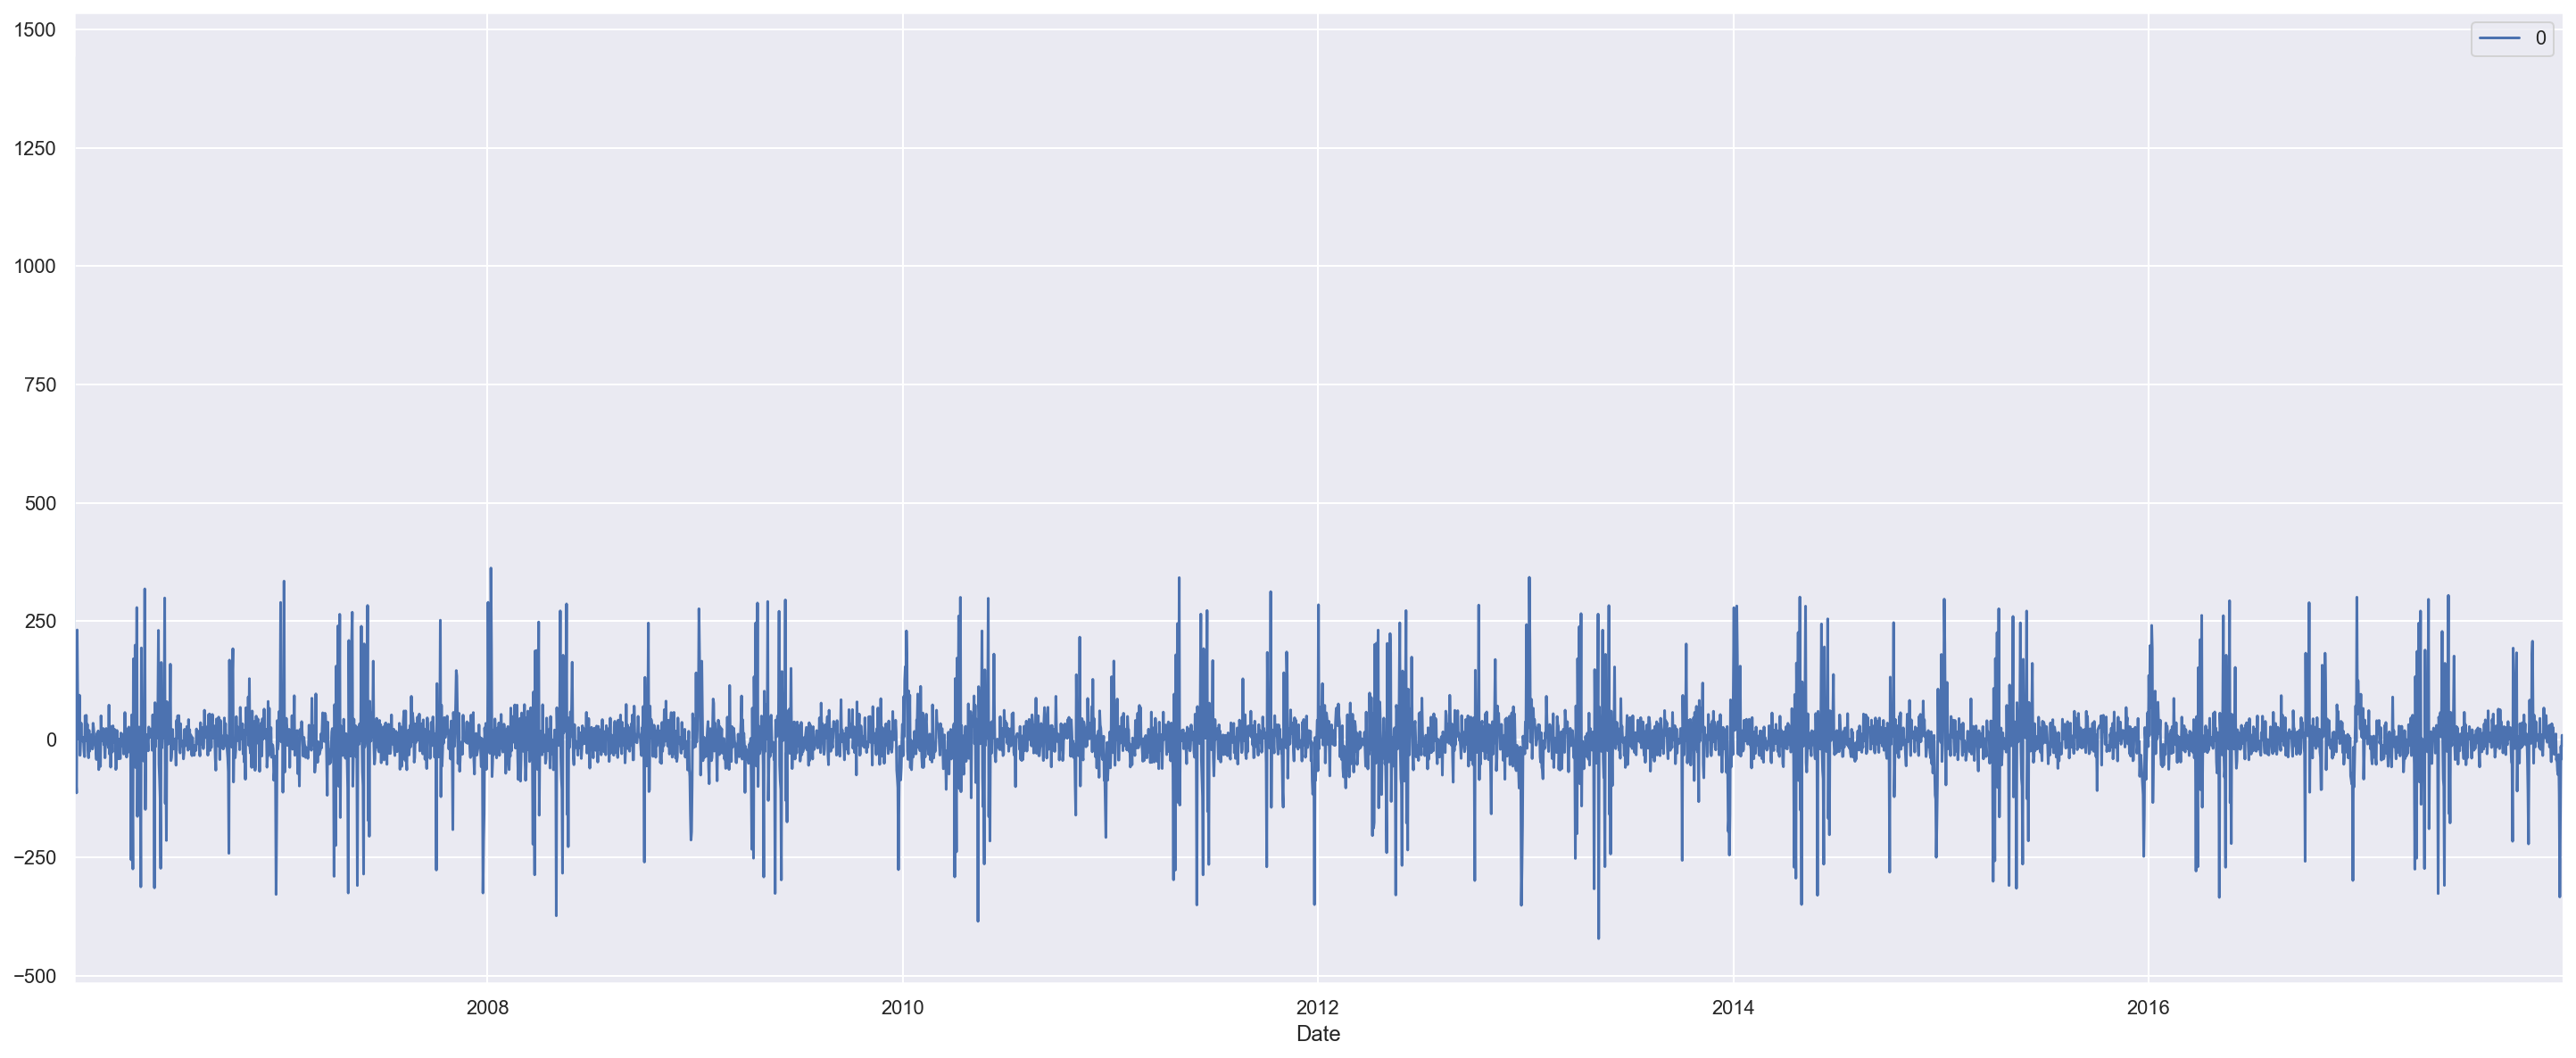

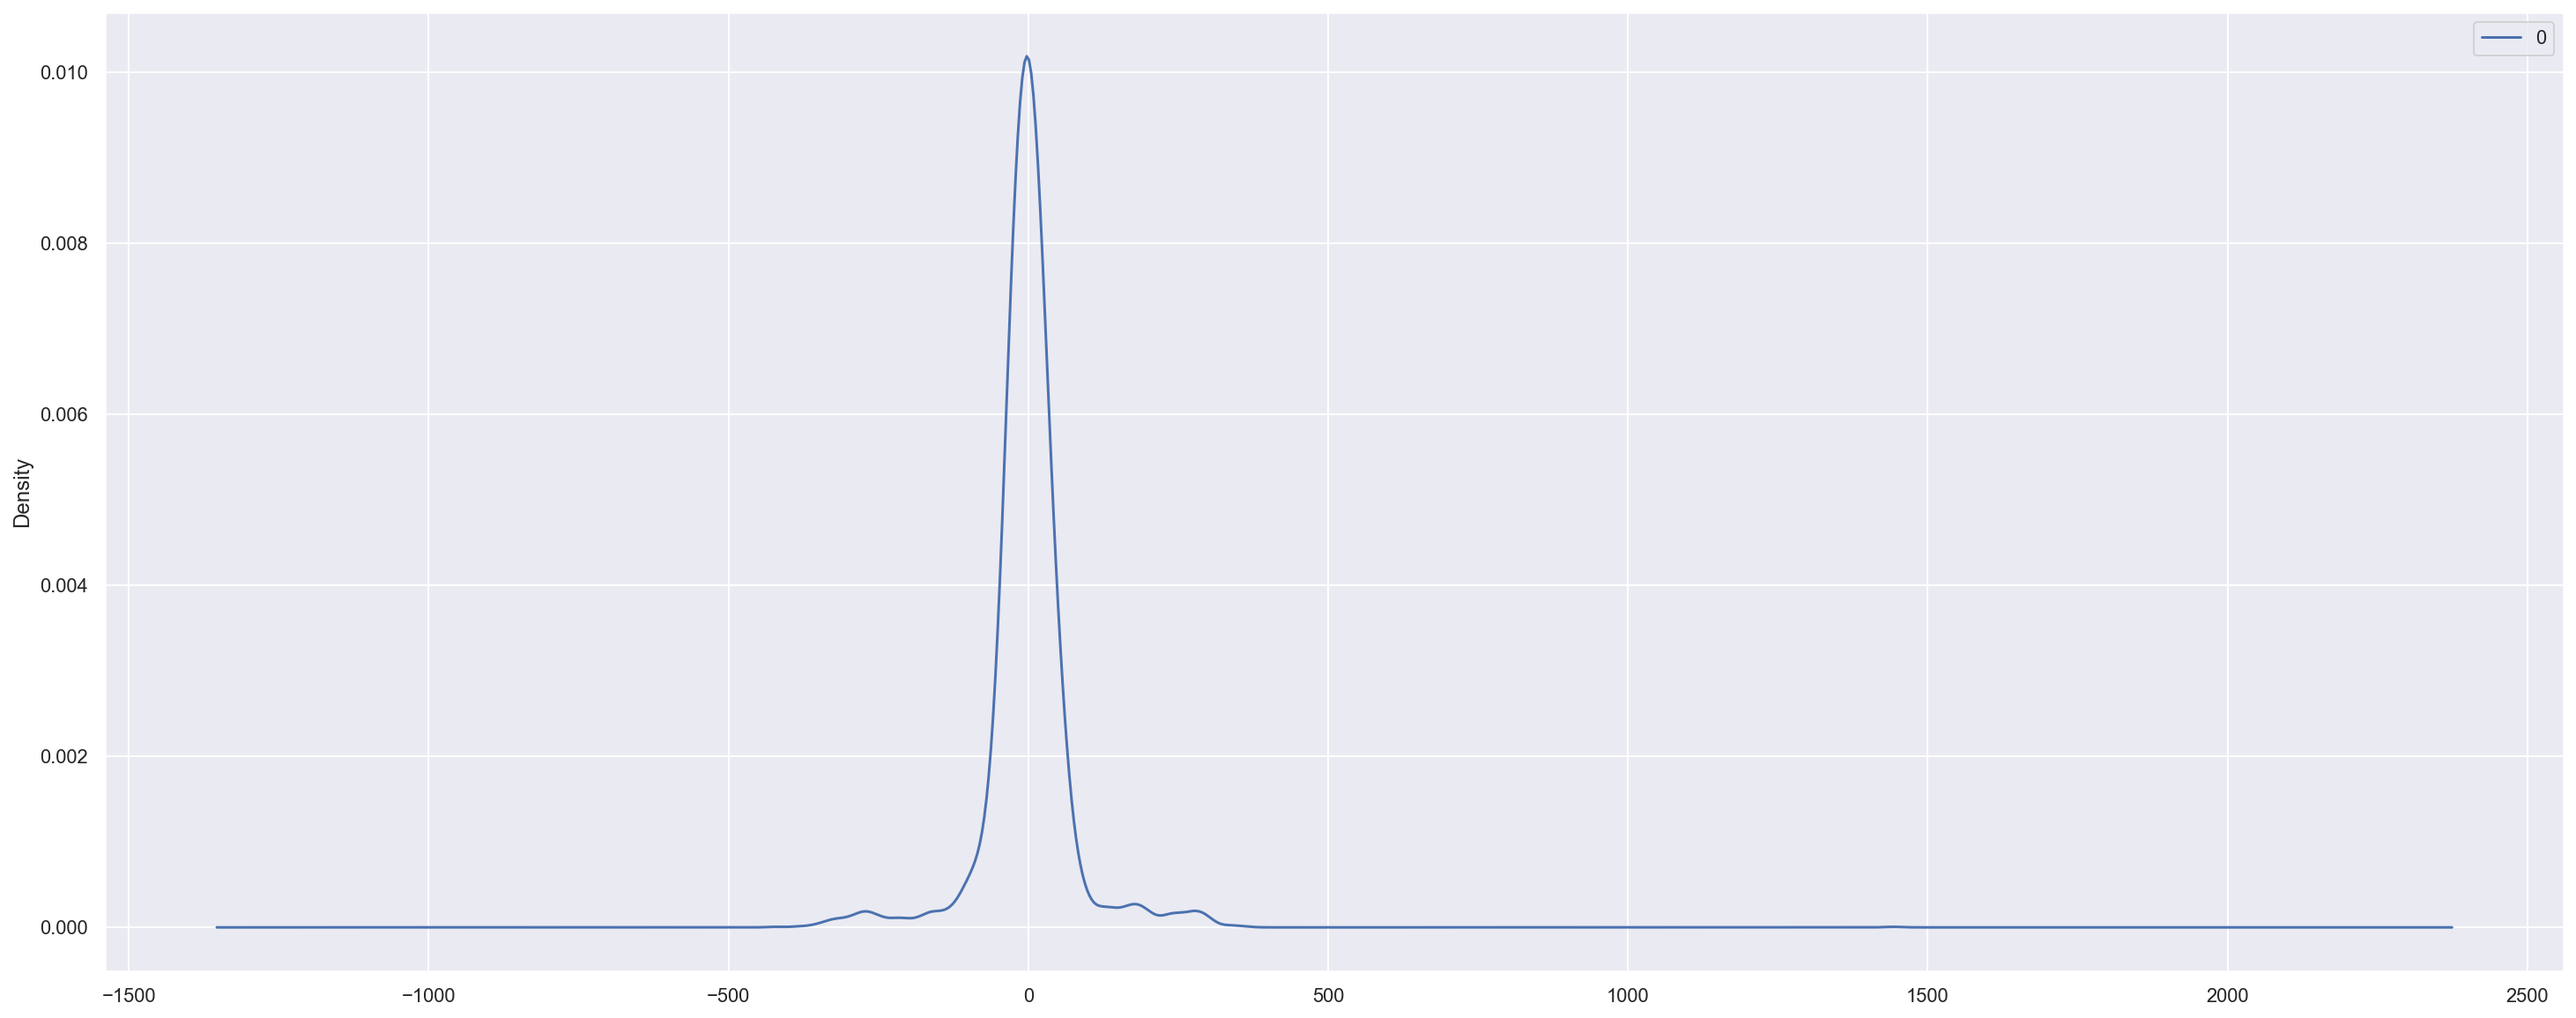

In [27]:
# line plot of residuals
residuals = pd.DataFrame(results_AR.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show();

In [28]:
# summary stats of residuals
print(residuals.describe())

                 0
count  4381.000000
mean      0.190240
std      74.024108
min    -421.507720
25%     -24.953719
50%      -0.663668
75%      24.744235
max    1442.533000


Quite normally distributed.

##### Rolling Time Window forecast

In [29]:
train, test = X_train[:, 0], X_test[:, 0]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(X_test)):
    model = ARIMA(history, order=(7,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if t % 100 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1141.687011, expected=1212.568000
predicted=1381.016500, expected=1430.915000
predicted=1384.476549, expected=1411.458000
predicted=1468.207584, expected=1480.503230


Test RMSE: 72.911


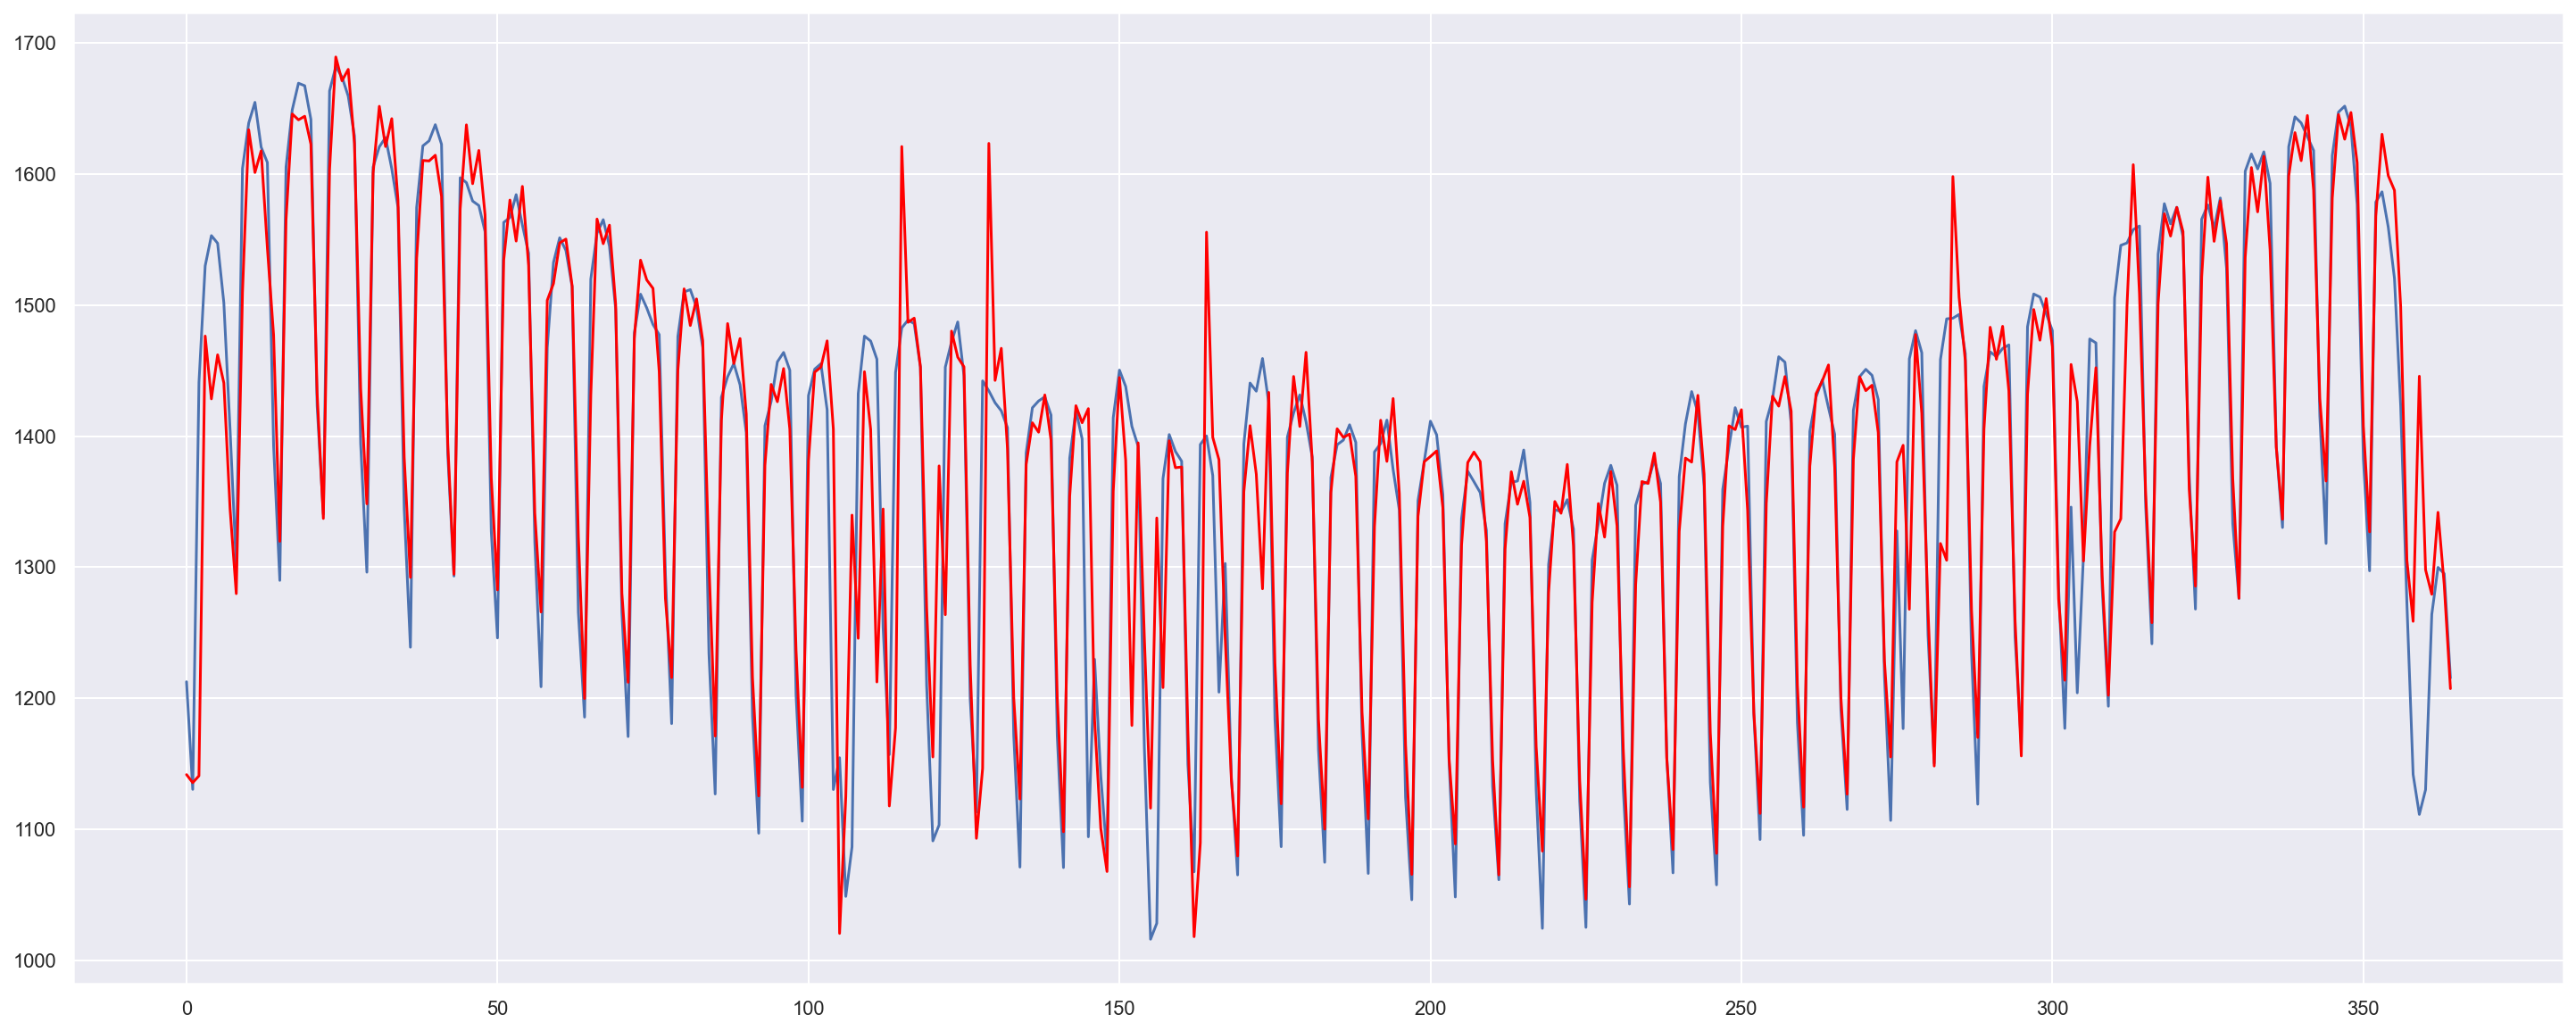

In [30]:
# evaluate forecasts
rmse_model = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_model)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show();

#### MA model

Let's set now $(p, d, q) = (0, 1, 2)$ to get the Moving Average model.

In [31]:
model = ARIMA(data_consumption['Consumption'].loc[:'2017'], order=(0, 1, 2))  
results_MA = model.fit()  
print(results_MA.summary())

/Users/oscar/miniconda3/envs/lectures/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                 4381
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -27234.323
Date:                Mon, 21 Feb 2022   AIC                          54474.646
Time:                        16:51:27   BIC                          54493.800
Sample:                    01-03-2006   HQIC                         54481.405
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2459      0.012    -21.236      0.000      -0.269      -0.223
ma.L2         -0.6690      0.012    -57.173      0.000      -0.692      -0.646
sigma2      1.473e+04    419.048     35.143      0.0

In [32]:
train, test = X_train[:, 0], X_test[:, 0]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(X_test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if t % 100 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))

/Users/oscar/miniconda3/envs/lectures/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=1341.371387, expected=1212.568000
predicted=1297.877111, expected=1430.915000
predicted=1298.064790, expected=1411.458000
predicted=1402.650260, expected=1480.503230


Test RMSE: 121.125


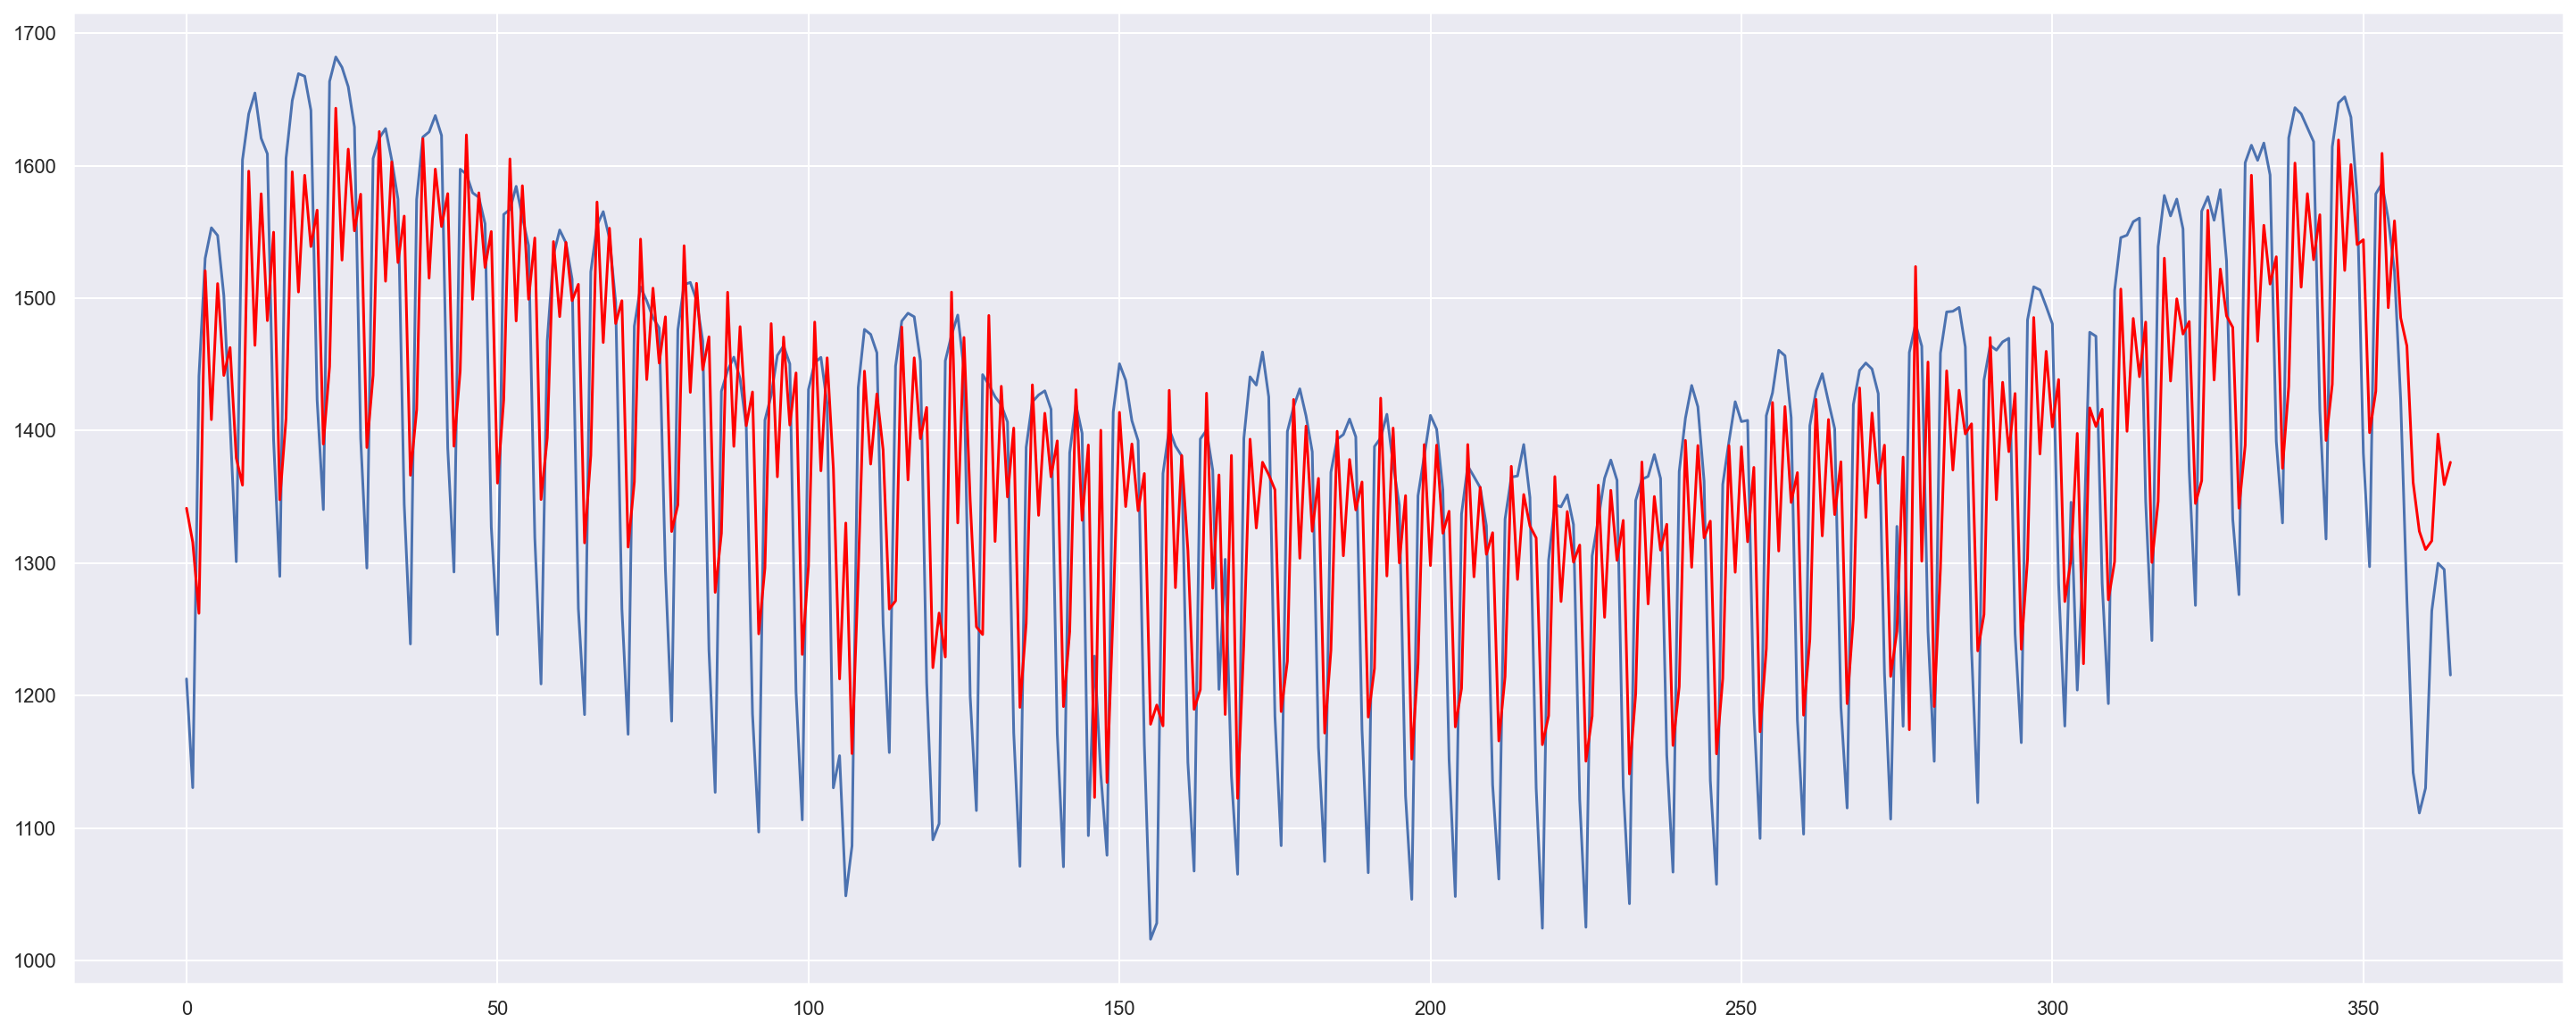

In [33]:
# evaluate forecasts
rmse_model = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_model)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show();

#### Full ARIMA model

Here we set $(p, d, q)$ all non-zero to get a combined AutoRegressive Integrated Moving Average model.

In [34]:
model = ARIMA(data_consumption['Consumption'].loc[:'2017'], order=(7, 1, 1))  
results_ARIMA = model.fit()  
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                 4381
Model:                 ARIMA(7, 1, 2)   Log Likelihood              -24857.596
Date:                Mon, 21 Feb 2022   AIC                          49735.193
Time:                        16:53:40   BIC                          49799.041
Sample:                    01-03-2006   HQIC                         49757.721
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2723      0.028     -9.834      0.000      -0.327      -0.218
ar.L2         -0.4053      0.026    -15.675      0.000      -0.456      -0.355
ar.L3         -0.2972      0.022    -13.208      0.0

In [35]:
train, test = X_train[100:, 0], X_test[100:, 0]
history = [x for x in train]
predictions = list()
# walk-forward validation
for i, t in enumerate(test):
    model = ARIMA(history, order=(7,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = t
    history.append(obs)
    if t % 100 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))

/Users/oscar/miniconda3/envs/lectures/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test RMSE: 82.821


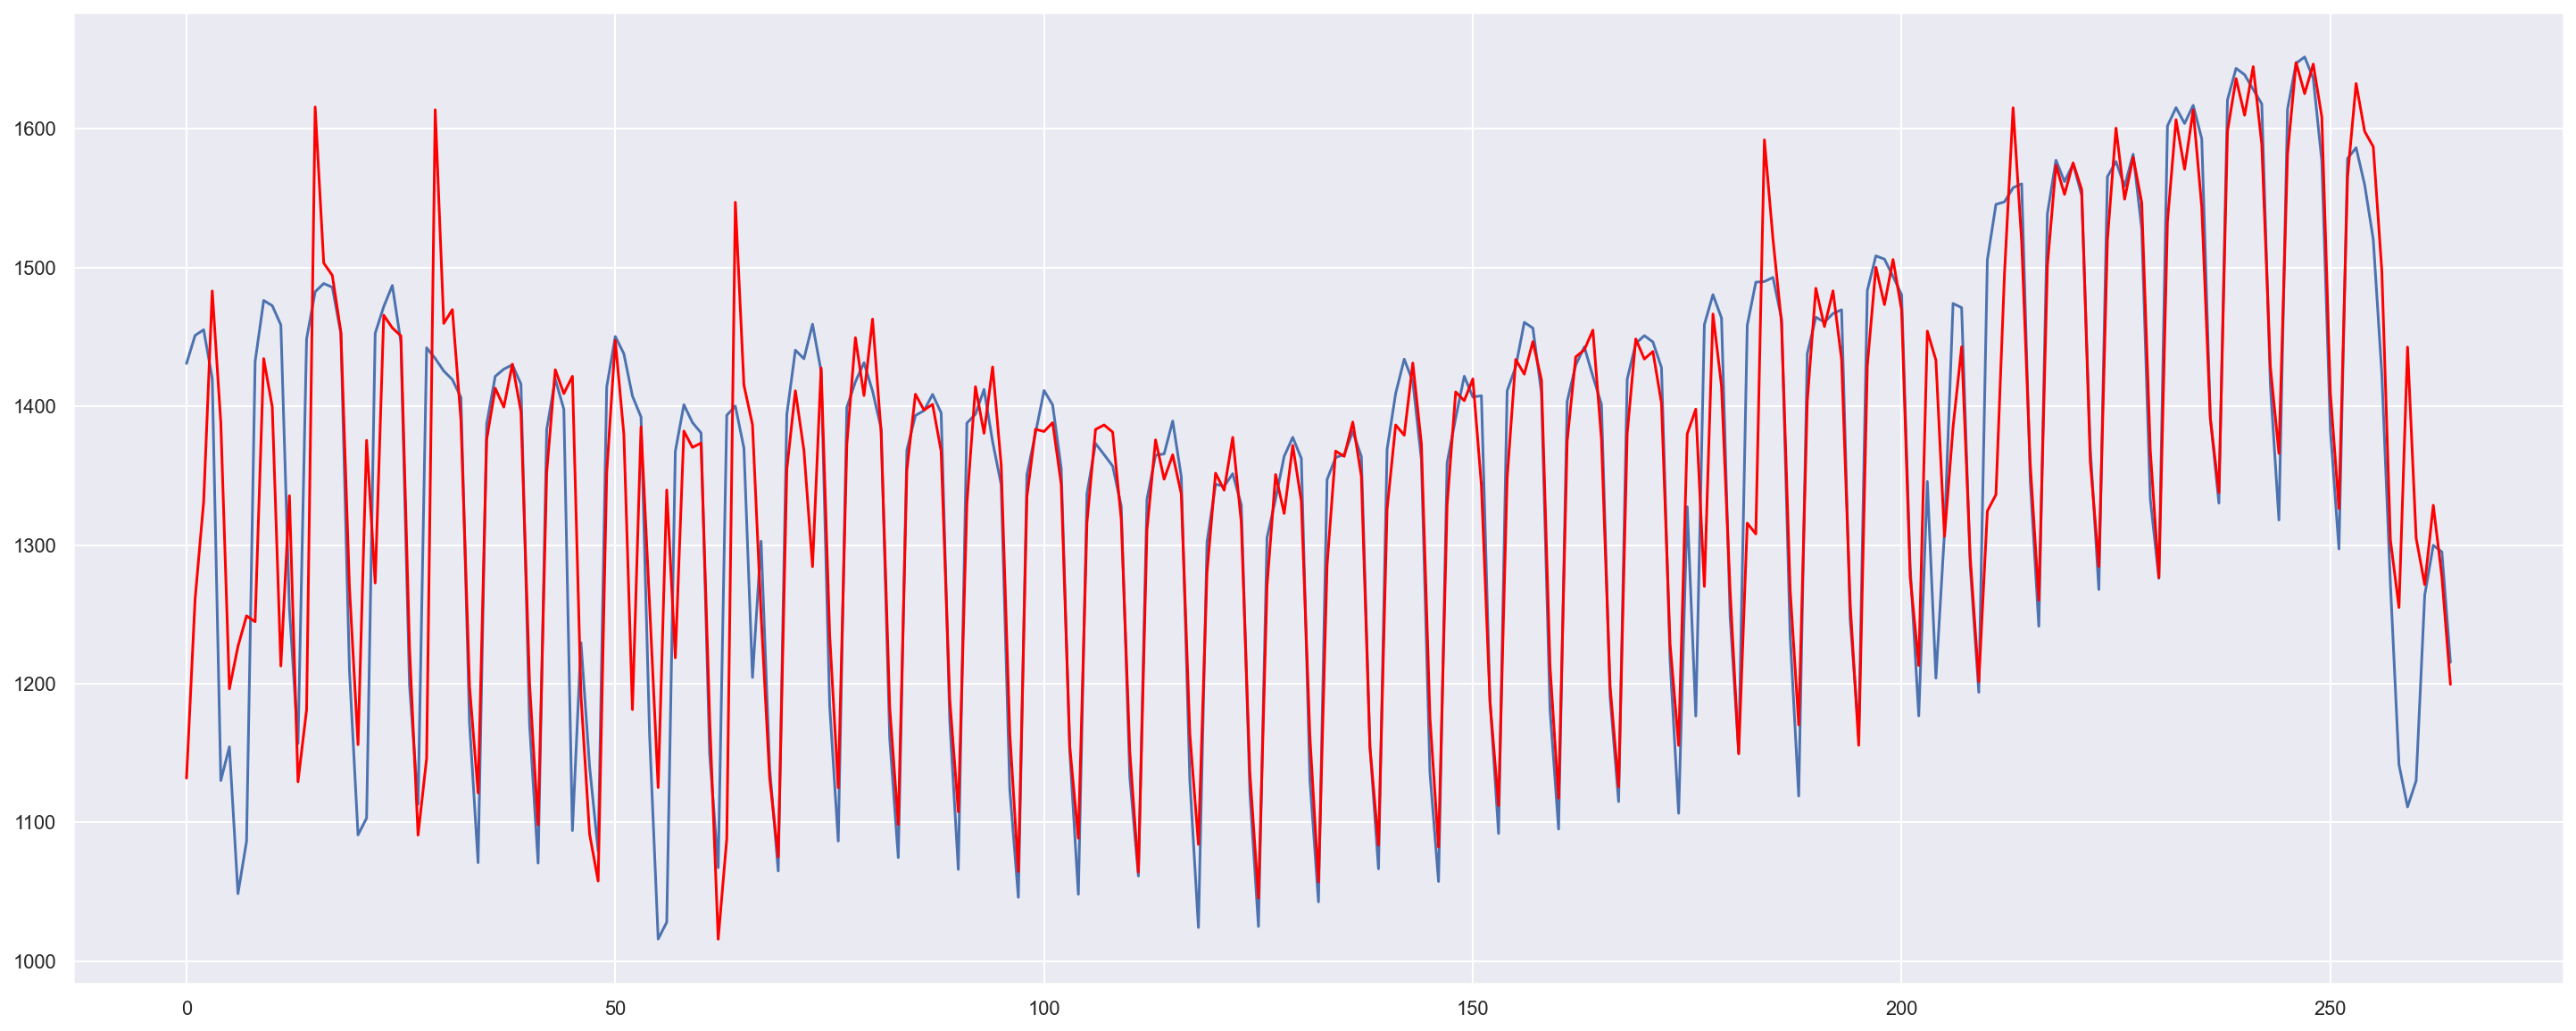

In [36]:
# evaluate forecasts
rmse_model = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_model)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show();

---
### Facebook Prophet

[Prophet](https://facebook.github.io/prophet/) is a forecasting procedure released by Facebook in 2017. Here are some of the features which make it a powerful and versatile tool:

* it is able to handle multiple seasonality and abrupt trend changes
* it is robust to missing data and outliers
* it is fairly out-of-the-box, while at the same time highly customizable.

Let's have a look.

First of all, let's reorganise our data into dataframes. 
Indeed, Prophet easily works with dataframes, though it requires a specific structure. We need two columns:

* `ds` for the temporal index
* `y` for the numerical values of the series.

We build the dataframe to pass to Prophet. We use Pandas `reset_index` to turn the temporal index into a standard column.

In [29]:
df = pd.read_csv(data_url,
                 parse_dates=True,
                 index_col='Date')

df_train = df.loc['2006':'2016']
df_test = df.loc['2017']

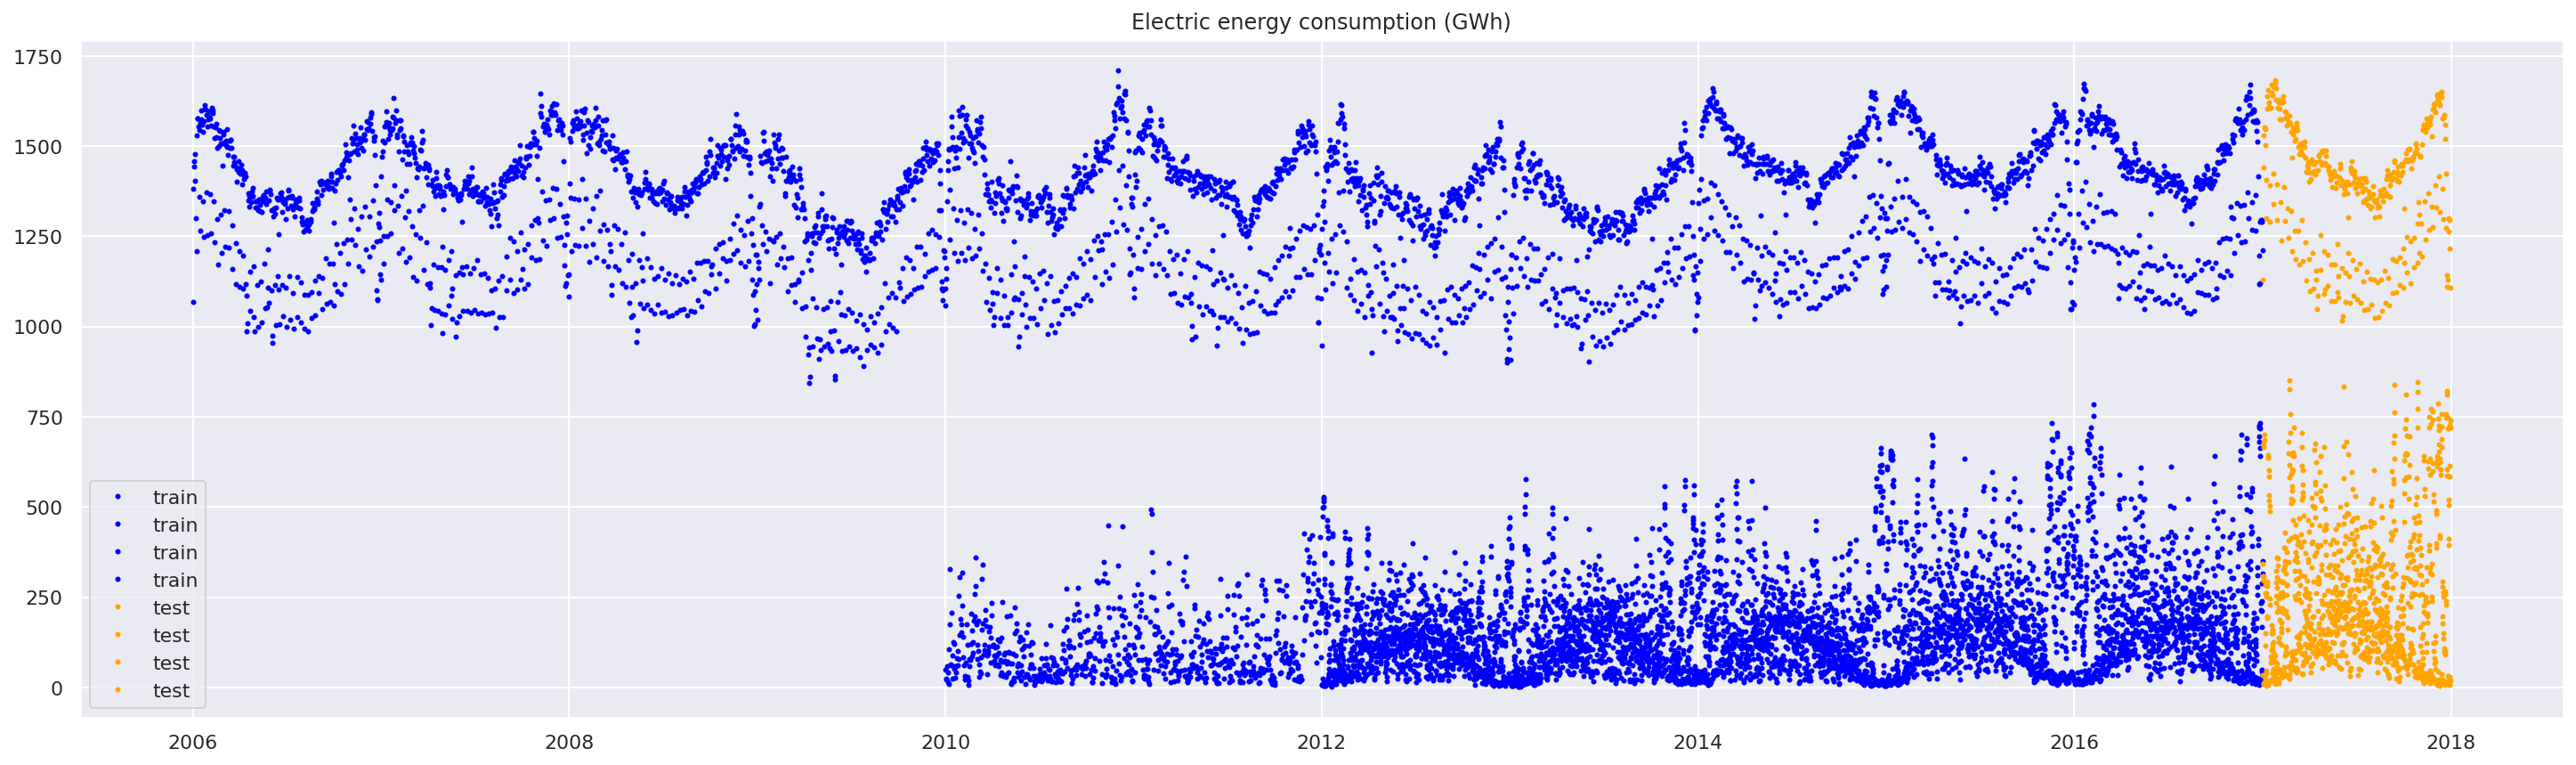

In [34]:
plt.figure(figsize=(25, 7))

plt.plot(df_train,
         marker='.',
         markersize=4,
         linestyle='',
         label='train',
         color='blue')

plt.plot(df_test,
         marker='.',
         markersize=4,
         linestyle='',
         label='test',
         color='orange')

plt.title('Electric energy consumption (GWh)')
plt.legend();

In [37]:
df_train_prophet = df_train[['Consumption']].reset_index()
df_train_prophet

Date  Consumption
0    2006-01-01     1069.184
1    2006-01-02     1380.521
2    2006-01-03     1442.533
3    2006-01-04     1457.217
4    2006-01-05     1477.131
...         ...          ...
4013 2016-12-27     1289.324
4014 2016-12-28     1294.881
4015 2016-12-29     1295.897
4016 2016-12-30     1291.044
4017 2016-12-31     1212.568

[4018 rows x 2 columns]

In [38]:
df_train_prophet.columns = ['ds', 'y']
df_train_prophet

ds         y
0    2006-01-01  1069.184
1    2006-01-02  1380.521
2    2006-01-03  1442.533
3    2006-01-04  1457.217
4    2006-01-05  1477.131
...         ...       ...
4013 2016-12-27  1289.324
4014 2016-12-28  1294.881
4015 2016-12-29  1295.897
4016 2016-12-30  1291.044
4017 2016-12-31  1212.568

[4018 rows x 2 columns]

We are finally ready for training. Prophet's syntax is very similar to the one of Scikit-learn.

In [39]:
model = Prophet()
model.fit(df_train_prophet);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Finally, let's build the data structure that will contain test predictions.

Note how this dataframe will contain just one column with the time index.

In [40]:
future = model.make_future_dataframe(periods=365, include_history=False)
future

ds
0   2017-01-01
1   2017-01-02
2   2017-01-03
3   2017-01-04
4   2017-01-05
..         ...
360 2017-12-27
361 2017-12-28
362 2017-12-29
363 2017-12-30
364 2017-12-31

[365 rows x 1 columns]

Let's apply the model in forecast. We pass the structure we just built to the predict function of the _trained_ Prophet model.

In [41]:
test_predictions = model.predict(future)

A dataframe is returned, containing several columns. The `yhat` column stores the numerical test predictions.

In [42]:
test_predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [43]:
test_predictions[['ds','yhat']]

ds         yhat
0   2017-01-01  1070.359223
1   2017-01-02  1366.503530
2   2017-01-03  1415.437838
3   2017-01-04  1431.843318
4   2017-01-05  1432.446372
..         ...          ...
360 2017-12-27  1384.882598
361 2017-12-28  1370.486134
362 2017-12-29  1344.202485
363 2017-12-30  1153.581943
364 2017-12-31  1060.494670

[365 rows x 2 columns]

We add these predictions to the test set's dataframe.

In [44]:
df_test['Prediction'] = test_predictions['yhat'].values
df_test

Consumption     Wind   Solar  Wind+Solar   Prediction
Date                                                             
2017-01-01   1130.41300  307.125  35.291     342.416  1070.359223
2017-01-02   1441.05200  295.099  12.479     307.578  1366.503530
2017-01-03   1529.99000  666.173   9.351     675.524  1415.437838
2017-01-04   1553.08300  686.578  12.814     699.392  1431.843318
2017-01-05   1547.23800  261.758  20.797     282.555  1432.446372
...                 ...      ...     ...         ...          ...
2017-12-27   1263.94091  394.507  16.530     411.037  1384.882598
2017-12-28   1299.86398  506.424  14.162     520.586  1370.486134
2017-12-29   1295.08753  584.277  29.854     614.131  1344.202485
2017-12-30   1215.44897  721.247   7.467     728.714  1153.581943
2017-12-31   1107.11488  721.176  19.980     741.156  1060.494670

[365 rows x 5 columns]

Let's compare the actual (test) consumption with that predicted by Prophet, in the most classical way: a plot.

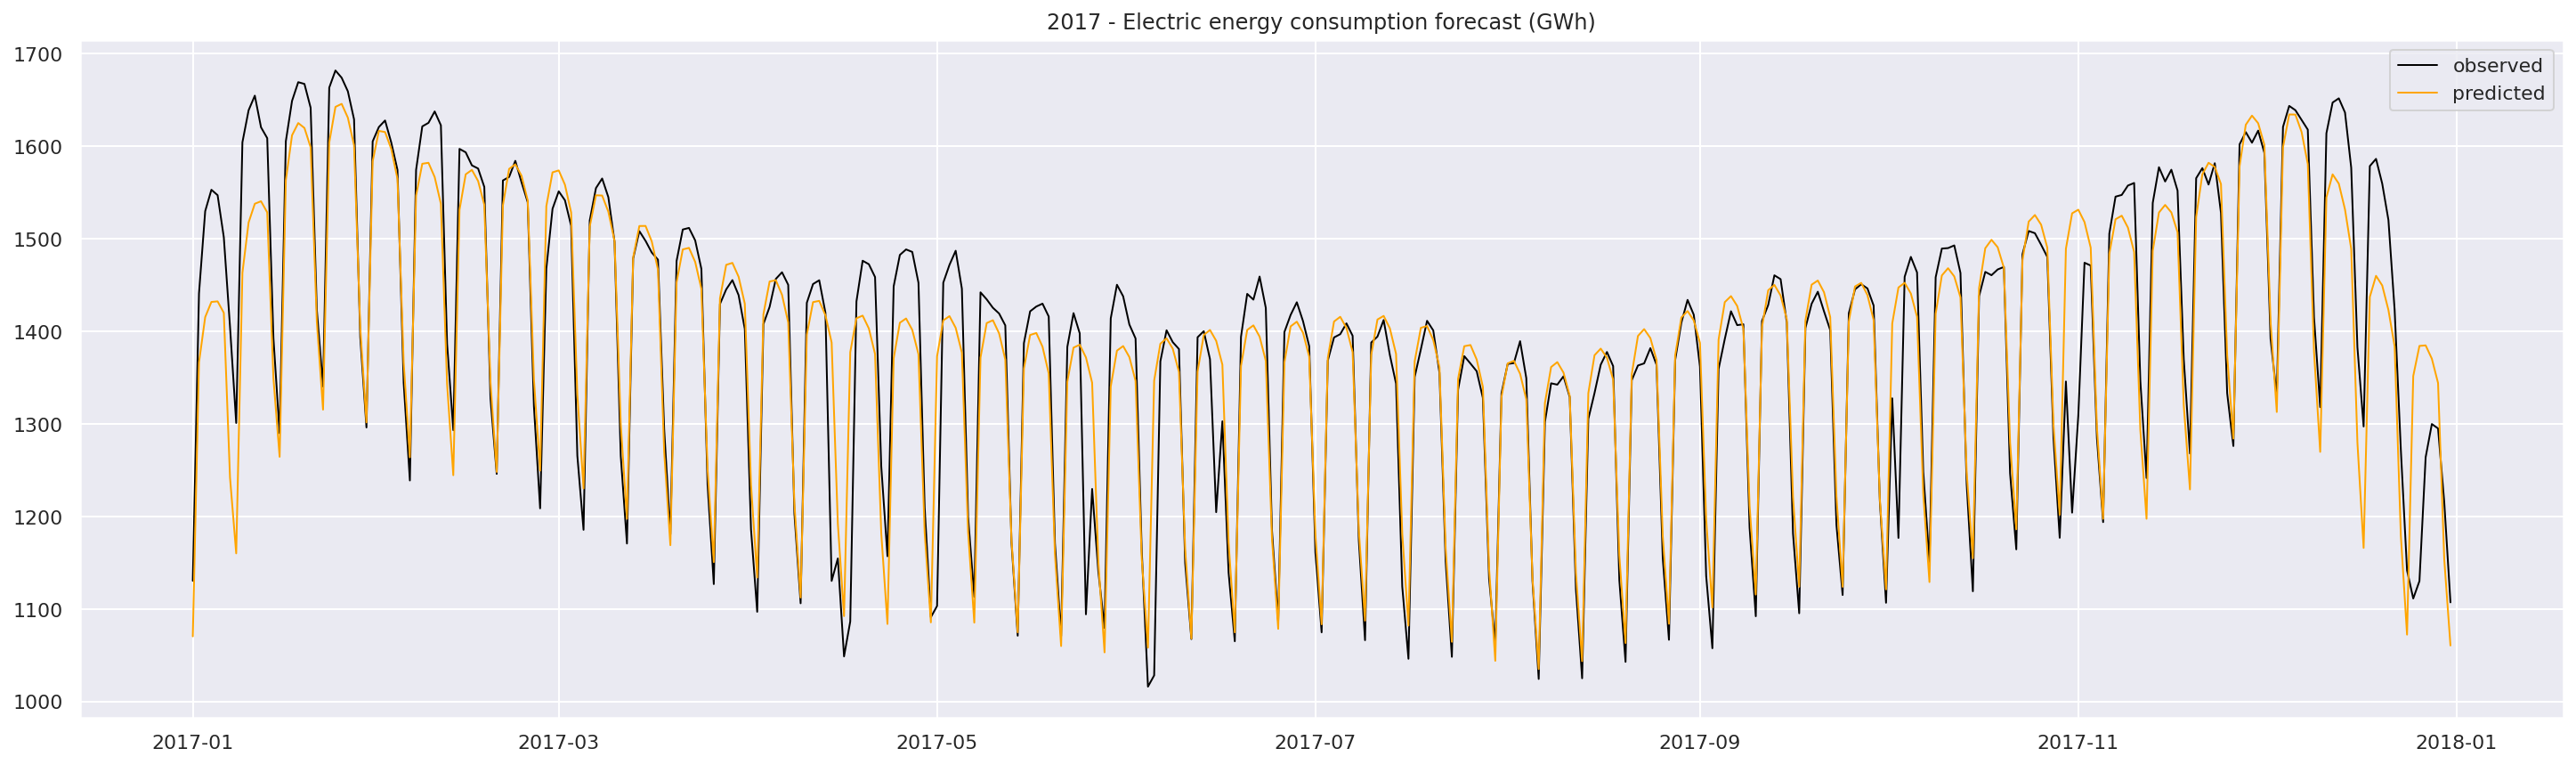

In [46]:
plt.figure(figsize=(25, 7))

plt.plot(df_test['Consumption'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Prediction'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.title('2017 - Electric energy consumption forecast (GWh)')
plt.legend();

**Recap**: so far, we have

1. split the data into training and test set
2. created the data structure required by Prophet for training and making predictions
3. trained a model on the training set
4. obtained test predictions
5. compared actual and predicted values.

Are we happy enough? What's next?

Like with standard supervised learning, we need to _quantitatively_ evaluate our predictions. We therefore need a __metric__ to quantify the error made by the trained model. You can have a look [here](https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python) and [here](https://otexts.com/fpp2/accuracy.html#accuracy).

A model has several __hyperparameters__ to be tuned, influencing the degree of fitting of training data. In Scikit-learn, these are implemented as arguments to be passed to the model at construction time. The same goes for Prophet.

Among them, we find `changepoint_prior_scale`. A [**changepoint**](https://facebook.github.io/prophet/docs/trend_changepoints.html) is a time instant at which the series abruptly changes its behaviour. By fine-tuning this hyperparameter, we set the model sensitivity to changepoints: 

![](https://github.com/fbagattini/Lezioni/raw/5fb4bc1b5a97d345da6fff9e66e19921bbc45176/img/changepoints.png)

Seasonality can be looked for or excluded from the model by setting the `daily_`, `weekly_` and `yearly_seasonality` arguments.

The graphical example above is taken from [here](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a); [this](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274) is another useful resource. Finally, [this](https://peerj.com/preprints/3190.pdf) is the original article.

---
### Exercise 
Forecast and represent the solar energy production of $2017$, by using years from $2012$ to $2016$ as training data. 

You should use at least 2 different models and compare results

---
## Extra resources


#### Python tools:

https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html.


#### Autocorrelation vs partial autocorrelation:

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
https://www.youtube.com/watch?v=ZjaBn93YPWo.


#### Forecast models:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
https://www.youtube.com/watch?v=d4Sn6ny_5LI.


#### Forecast as supervised learning:

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/.


#### Datasets and notebooks:

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
https://machinelearningmastery.com/time-series-datasets-for-machine-learning/
https://www.kaggle.com/search?q=time+series.

### Some other libraries to look at
1. [neural prophet](https://github.com/ourownstory/neural_prophet)
2. [sktime](https://www.sktime.org/en/stable/)
3. [tslearn](https://tslearn.readthedocs.io/en/stable/)
4. [TBATS](https://github.com/intive-DataScience/tbats)
5. [darts](https://github.com/unit8co/darts)